In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/ABIDE/")

Mounted at /content/drive


In [ ]:
!pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install torch-geometric==2.2.0
import torch
print(torch.__version__)
print(torch.version.cuda)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.0+cu121
    Uninstalling torch-2.5.0+cu121:
      Successfully uninstalled torch-2.5.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.0+cu121
    Uninstalling torchvision-0.20.0+cu121:
      Successfully uninstalled torchvision-0.20.0+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.5.0+cu121
    Uninstalling torchaudio-2.5.0+cu121:
      Successfully uninstalled torchaudio-2.5.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.13.2 requires torch>=1.13.0, but you 

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ABIDE/')

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn import svm
import joblib
import openpyxl
from openpyxl import load_workbook
import os
import scipy.io as scio
import argparse
import numpy as np
import time
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils
from os.path import join
from os import listdir
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import DataLoader
from collections import OrderedDict
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 as cv
from os import path
import shutil
import scipy.stats
import scipy.ndimage
import random
import torch.nn.init as init
import torch.nn.functional as F
import sys
import math
from functools import reduce
import operator
from scipy.interpolate import interp1d
from torch.optim import lr_scheduler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def feature_selection_fMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector
def feature_selection_sMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector

def get_index(lst=None, item=''):
	return [i for i in range(len(lst)) if lst[i] == item]

def flatten_one(length, img):
	'''
	  In some situations, the dimension on z-axis of images are smaller than
	  the dimension of z-axis of patches, this function will be used to pad
	'''

	one_line = np.zeros((1, int(length)))
	position = 0
	for i in range(img.shape[0]):  # column
		for j in range(i + 1, img.shape[1]):  # row
			one_line[0, position] = img[j, i]
			position = position + 1
	return one_line


def get_ids(num_subjects=None,dir_path=''):
	"""
	return:
		subject_IDs    : list of all subject IDs
	"""
	subject_IDs = np.genfromtxt(os.path.join(dir_path, 'subject_IDs.txt'), dtype=str)

	if num_subjects is not None:
		subject_IDs = subject_IDs[:num_subjects]

	return subject_IDs

def save_model(net,path, name_net):

  # This fucntion is used to save a specific model

    path_net =  path + '/' + name_net + '.pth'
    torch.save(net.cpu().state_dict(), path_net)
    net.cuda()

def load_model(net, path, name_net):

  # This function is used to load a specific model we saved before

    path_net =  path + '/' + name_net + '.pth'
    net.load_state_dict(torch.load(path_net))

    return net



In [ ]:
########################################### Load Data ###############################################
#####################################################################################################
#####################################################################################################
fMRI_atlas = 'CC200'  # AAL or CC200
phe = False

if phe == False:
  save_phe = '/without_phe/'
else:
  save_phe = '/with_phe/'


save_path = '/content/drive/MyDrive/ABIDE/save_models/CC200_sMRI/'+ save_phe
root_path_fMRI = '/content/dataset'
if os.path.exists(root_path_fMRI):
  shutil.rmtree(root_path_fMRI)
shutil.copytree('/content/drive/MyDrive/ABIDE/' + fMRI_atlas + '/original/', root_path_fMRI)
label_dir = '/content/drive/MyDrive/ABIDE/phenotypic_image_quality'

# sMRI path
localDir = '/content/sMRI_dataset/'
if os.path.exists(localDir):
  shutil.rmtree(localDir)
os.makedirs(localDir)
!unzip '/content/drive/MyDrive/ABIDE/freesurfer_stats.zip' -d '/content/sMRI_dataset'
localDir = localDir + 'freesurfer_stats/'


k_fold = 5
new_number_features_fMRI = 4000
new_number_features_sMRI = 800
number_samples = 871
useless_samples = ['51334']
if fMRI_atlas == 'AAL':
  image_size = [116, 116]
else:
  image_size = [200, 200]
scaler = True


age_name = 'ages.mat'
gender_name = 'genders.mat'
label_name = 'ABIDE_label_871.mat'
label = scio.loadmat(os.path.join(label_dir, label_name))
label = label['label'][0]
labels = np.zeros(number_samples - len(useless_samples))
site_name = 'sites.mat'
site = scio.loadmat(os.path.join(label_dir, site_name))
all_sites = site['sites']
for i in range(len(all_sites)):
	site = all_sites[i]
	all_sites[i] = site.replace(' ', '')
unique_sites = np.unique(all_sites)
sites = []
unique_sites = list(unique_sites)

gender = scio.loadmat(os.path.join(label_dir, gender_name))
gender = gender['genders']
genders = np.zeros((number_samples - len(useless_samples), 1))

age = scio.loadmat(os.path.join(label_dir, age_name))
age = age['ages']
ages = np.zeros((number_samples - len(useless_samples), 1))

subject_IDs = get_ids(number_samples,dir_path=label_dir)
subject_IDs = subject_IDs.tolist()
length = image_size[0] * (image_size[1]-1) / 2
fMRI_images = np.zeros((number_samples - len(useless_samples), int(length)))

position = 0
print('constructing fMRI features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    image_name = subject_name + '.mat'
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    image = scio.loadmat(os.path.join(root_path_fMRI, image_name))
    img = image['connectivity']

    idx = np.triu_indices_from(img, 1)
    fMRI_images[position, :] = img[idx]
    sites.append(all_sites[subject_index[0]])
    labels[position] = label[subject_index[0]]
    genders[position] = int(gender[subject_index[0]]) + 1
    ages[position] = float(age[subject_index[0]].replace(' ', ''))
    position = position + 1

if scaler == True:
	fMRI_images = StandardScaler().fit_transform(fMRI_images)

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/brainvol.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.DKTatlas.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.pial.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.thresh.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.curv.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.w-g.pct.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.DKTatlas.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.pial.stats  
  inflating: /c

In [ ]:
fMRI_feature_names = []
for i in range(1,img.shape[0]+1):
  for j in range(i+1,img.shape[0]+1):
    connection_brain_regions=[]
    connection_brain_regions.append(i)
    connection_brain_regions.append(j)
    fMRI_feature_names.append(connection_brain_regions)
print(fMRI_feature_names)

[[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23], [1, 24], [1, 25], [1, 26], [1, 27], [1, 28], [1, 29], [1, 30], [1, 31], [1, 32], [1, 33], [1, 34], [1, 35], [1, 36], [1, 37], [1, 38], [1, 39], [1, 40], [1, 41], [1, 42], [1, 43], [1, 44], [1, 45], [1, 46], [1, 47], [1, 48], [1, 49], [1, 50], [1, 51], [1, 52], [1, 53], [1, 54], [1, 55], [1, 56], [1, 57], [1, 58], [1, 59], [1, 60], [1, 61], [1, 62], [1, 63], [1, 64], [1, 65], [1, 66], [1, 67], [1, 68], [1, 69], [1, 70], [1, 71], [1, 72], [1, 73], [1, 74], [1, 75], [1, 76], [1, 77], [1, 78], [1, 79], [1, 80], [1, 81], [1, 82], [1, 83], [1, 84], [1, 85], [1, 86], [1, 87], [1, 88], [1, 89], [1, 90], [1, 91], [1, 92], [1, 93], [1, 94], [1, 95], [1, 96], [1, 97], [1, 98], [1, 99], [1, 100], [1, 101], [1, 102], [1, 103], [1, 104], [1, 105], [1, 106], [1, 107], [1, 108], [1, 109], [1, 110], [1, 111], [1, 1

In [ ]:
sMRI_feature_names = []

############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load Desikan_Killiany_features
left = 'lh.aparc.stats'
right = 'rh.aparc.stats'
number_roi = 68
feature_list = ['NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
names = ['StructName', 'NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
skiprows= list(range(0,61))
Desikan_Killiany_features = np.zeros((number_samples - len(useless_samples), number_roi * len(feature_list)))


position = 0
print('constructing Desikan-Killiany Atlas features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    table_left = pd.read_table(localDir + subject_name + '/' + left, sep='\s+', names=names,
						  skiprows=skiprows)
    table_right = pd.read_table(localDir + subject_name + '/' + right, sep='\s+', names=names,
						  skiprows=skiprows)
    if i == 0:
      left_names = table_left['StructName'].values.tolist()
      left_names = [['lh',k] for k in left_names]
      right_names = table_right['StructName'].values.tolist()
      right_names = [['lh',k] for k in right_names]

    for j in range(len(feature_list)):
      feature_name = feature_list[j]
      left_features = table_left[feature_name].values.tolist()
      right_features = table_right[feature_name].values.tolist()
      all_features = left_features + right_features
      if len(all_features) != number_roi:
       print('The sample ' + subject_name + ' has mistake!')
      all_features = np.array(all_features)
      Desikan_Killiany_features[position, j*number_roi : (j+1)*number_roi] = all_features

      if i == 0:
        left_dk_names = [ [*k,feature_name] for k in left_names]
        right_dk_names = [ [*k,feature_name] for k in right_names]
        sMRI_feature_names = sMRI_feature_names + left_dk_names + right_dk_names
    position = position + 1

if scaler == True:
	for i in range(len(feature_list)):
		Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi] = StandardScaler().fit_transform(Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi])

print('finished')




############################################### Load aseg features
print('constructing aseg features')
number_roi_aseg = 45
aseg = 'aseg.stats'
feature_list_aseg = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_aseg = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_aseg= list(range(0,79))
aseg_features = np.zeros((number_samples - len(useless_samples), number_roi_aseg * len(feature_list_aseg)))

position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + aseg, sep='\s+', names=names_aseg,
						  skiprows=skiprows_aseg)
		if i == 0:
			left_names = table_left['Structure Name'].values.tolist()
			left_names = [['_',k] for k in left_names]

		for j in range(len(feature_list_aseg)):
			feature_name = feature_list_aseg[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_aseg:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			aseg_features[position, j*number_roi_aseg : (j+1)*number_roi_aseg] = all_features
			if i == 0:
				as_names = [[*k,feature_name] for k in left_names]
				sMRI_feature_names = sMRI_feature_names + as_names


		position = position + 1

if scaler == True:
	for i in range(len(feature_list_aseg)):
		aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg] = StandardScaler().fit_transform(aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg])
print('finished')



############################################### Load wmparc features
number_roi_wmparc = 70
wmparc = 'wmparc.stats'
feature_list_wmparc = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_wmparc = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_wmparc= list(range(0,65))
wmparc_features = np.zeros((number_samples - len(useless_samples), number_roi_wmparc * len(feature_list_wmparc)))

print('constructing wmparc features')
position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + wmparc, sep='\s+', names = names_wmparc,
						  skiprows=skiprows_wmparc)

		if i == 0:
			left_names = table_left['Structure Name'].values.tolist()
			left_names = [['_',k] for k in left_names]
		for j in range(len(feature_list_wmparc)):
			feature_name = feature_list_wmparc[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_wmparc:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			wmparc_features[position, j*number_roi_wmparc : (j+1)*number_roi_wmparc] = all_features

			if i == 0:
				wm_names = [[*k,feature_name] for k in left_names]
				sMRI_feature_names = sMRI_feature_names + wm_names

		position = position + 1
if scaler == True:
	for i in range(len(feature_list_wmparc)):
		wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc] = StandardScaler().fit_transform(wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc])
print('finished')

############################################### concatenation
sMRI_features = np.concatenate((Desikan_Killiany_features, aseg_features, wmparc_features),axis = 1)
print(sMRI_feature_names)
print(len(sMRI_feature_names))

constructing Desikan-Killiany Atlas features
The index for sample 51334 is :  [799]
finished
constructing aseg features
The index for sample 51334 is :  [799]
finished
constructing wmparc features
The index for sample 51334 is :  [799]
finished
[['lh', 'bankssts', 'NumVert'], ['lh', 'caudalanteriorcingulate', 'NumVert'], ['lh', 'caudalmiddlefrontal', 'NumVert'], ['lh', 'cuneus', 'NumVert'], ['lh', 'entorhinal', 'NumVert'], ['lh', 'fusiform', 'NumVert'], ['lh', 'inferiorparietal', 'NumVert'], ['lh', 'inferiortemporal', 'NumVert'], ['lh', 'isthmuscingulate', 'NumVert'], ['lh', 'lateraloccipital', 'NumVert'], ['lh', 'lateralorbitofrontal', 'NumVert'], ['lh', 'lingual', 'NumVert'], ['lh', 'medialorbitofrontal', 'NumVert'], ['lh', 'middletemporal', 'NumVert'], ['lh', 'parahippocampal', 'NumVert'], ['lh', 'paracentral', 'NumVert'], ['lh', 'parsopercularis', 'NumVert'], ['lh', 'parsorbitalis', 'NumVert'], ['lh', 'parstriangularis', 'NumVert'], ['lh', 'pericalcarine', 'NumVert'], ['lh', 'postc

In [ ]:
print(sMRI_features.shape)
print(len(sMRI_feature_names))

(870, 1417)
1417


In [ ]:
FCN_labels = np.zeros((number_samples - len(useless_samples), 2))
for i in range(len(labels)):
    if labels[i] == 1:
        FCN_labels[i,0] = 1
    else:
        FCN_labels[i,1] = 1

# data = {}
# for fold in range(1, 1+1):

#   data[str(fold)] = []
#   selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
#   selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

#   new_fMRI_data = selector_fMRI.transform(fMRI_images)
#   new_sMRI_data = selector_sMRI.transform(sMRI_features)
#   ################################################# combine ##########################################
#   if phe == True:
#     fold_data = np.concatenate((new_fMRI_data,new_sMRI_data,phe_features), axis = 1)
#     print(fold_data.shape)
#   else:
#     fold_data = np.concatenate((new_fMRI_data,new_sMRI_data), axis = 1)
#     print(fold_data.shape)

#   data[str(fold)].append(fold_data)
#   data[str(fold)].append(FCN_labels)


# Interpretation methods for FCN (ABIDE) with ensemble---generating saliency maps


In the last step, we apply 4 gradient based interpretation mehtods to GCN model within the ensamble section.

5 outer loop, 5 inner loop. In each inner loop, apply 1~5 models to generate 4 saliency maps for each subject in the test set. Basically, each test subject will have 20 saliency maps from 4 interpretation methods and 5 different inner models

In [ ]:
save_selected_features = {}


import math


def normalization_vanilla(vanilla):
  index_neg = np.where(vanilla<0)
  print(index_neg)
  abs_vanilla = np.abs(vanilla)
  std = np.std(abs_vanilla)
  new_vanilla = abs_vanilla / std
  new_vanilla[index_neg] = 0 - new_vanilla[index_neg]

  return new_vanilla



def normalization_smooth(smooth):
  std = np.std(smooth)
  new_smooth = smooth / std

  return new_smooth



torch.cuda.empty_cache()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
dist_ensemble_val_label = {}
dist_ensemble_val_result = {}
dist_ensemble_test_label = {}
dist_ensemble_test_result = {}
dist_ensemble_test_prob = {}

dist_fMRI = {}
dist_sMRI = {}

# np.save('/content/drive/MyDrive/ABIDE/test_save_selected_features/sMRI_rigid_nested.npy', dist_sMRI)
save_saliency = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/fcn/'
target_index = None
n_samples = 10
for ensemble_fold in range(2,5):
  print('Ensemble ',ensemble_fold+1)
  save_ensemble_models_path = save_path + 'Max_voting/FCN/'
  dist_train = {}
  dist_validation = {}
  dist_test = {}
  for i in range(k_fold):
    dist_train[str(i + 1)] = []
    dist_validation[str(i + 1)] = []
    dist_test[str(i + 1)] = []
  test_name = {}
  for i in range(len(unique_sites)):
    test_name[unique_sites[i]] = []
  for each_site in unique_sites:
    index_site = get_index(sites, each_site)
    label = np.zeros((len(index_site)))
    for i in range(len(index_site)):
      index = index_site[i]
      label[i] = int(labels[int(index)])
    test_name_list = test_name[each_site]
    ########################################### StratifiedKFold ####################################################
    sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
    group = 0
    for train, validation in sfolder.split(index_site,label):
      if group == ensemble_fold:
        for j in validation:
          name = index_site[j]
          dist_test['1'].append(name)
          dist_test['2'].append(name)
          dist_test['3'].append(name)
          dist_test['4'].append(name)
          dist_test['5'].append(name)
          test_name_list.append(name)
      group = group + 1
    test_name[each_site] = test_name_list

  for each_site in unique_sites:
    if ensemble_fold == 0:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      if each_site == 'CMU':  # ONLY 4 AUTISM SAMPLES AND 4 TD SAMPLES, CAN NOT BE DEVIDED INTO 5 GROUPS
        group_autism_val = []
        group_autism_train = []
        group_TD_val = []
        group_TD_train = []
        autism_validation_number = len(label_new[label_new ==1])/4
        TD_validation_number = len(label_new[label_new ==0]) / 4
        for j in range(len(label_new)):
          if label_new[j] == 1:
            if len(group_autism_val)<autism_validation_number:
              group_autism_val.append(index_site_new[j])
            else:
              group_autism_train.append(index_site_new[j])
          else:
            if len(group_TD_val)<TD_validation_number:
              group_TD_val.append(index_site_new[j])
            else:
              group_TD_train.append(index_site_new[j])

        dist_validation['1'] = dist_validation['1'] + group_autism_val + group_TD_val
        dist_validation['2'] = dist_validation['2'] + group_autism_val + group_TD_val
        dist_validation['3'] = dist_validation['3'] + group_autism_val + group_TD_val
        dist_validation['4'] = dist_validation['4'] + group_autism_val + group_TD_val
        dist_validation['5'] = dist_validation['5'] + group_autism_val + group_TD_val
        dist_train['1'] = dist_train['1'] + group_autism_train + group_TD_train
        dist_train['2'] = dist_train['2'] + group_autism_train + group_TD_train
        dist_train['3'] = dist_train['3'] + group_autism_train + group_TD_train
        dist_train['4'] = dist_train['4'] + group_autism_train + group_TD_train
        dist_train['5'] = dist_train['5'] + group_autism_train + group_TD_train
      else:
        ########################################### StratifiedKFold ####################################################
        sfolder = StratifiedKFold(n_splits=k_fold, random_state=0, shuffle=True)
        group = 0
        for train, validation in sfolder.split(index_site_new, label_new):

          for i in train:
            name = index_site_new[i]
            dist_train[str(group + 1)].append(name)
          for j in validation:
            name = index_site_new[j]
            dist_validation[str(group + 1)].append(name)
          group = group + 1
    else:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      ########################################### StratifiedKFold ####################################################
      sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
      group = 0
      for train, validation in sfolder.split(index_site_new,label_new):

        for i in train:
          name = index_site_new[i]
          dist_train[str(group + 1)].append(name)
        for j in validation:
          name = index_site_new[j]
          dist_validation[str(group + 1)].append(name)
        group = group+1


  data = {}
  for fold in range(1, k_fold+1):
    data[str(fold)] = []
    selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
    selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)



    ranking_sMRI = selector_sMRI.ranking_
    ranking_fMRI = selector_fMRI.ranking_
    dist_sMRI[str(ensemble_fold+1)+'_'+str(fold)]=ranking_sMRI
    dist_fMRI[str(ensemble_fold+1)+'_'+str(fold)]=ranking_fMRI
    new_fMRI_data = selector_fMRI.transform(fMRI_images)
    new_sMRI_data = selector_sMRI.transform(sMRI_features)
    ################################################# combine ##########################################
    if phe == True:
      fold_data = np.concatenate((new_fMRI_data,new_sMRI_data,phe_features), axis = 1)
      print(fold_data.shape)
    else:
      fold_data = np.concatenate((new_fMRI_data,new_sMRI_data), axis = 1)
      print(fold_data.shape)

    data[str(fold)].append(fold_data)
    data[str(fold)].append(FCN_labels)

  ############################################### interpretation ###############################################################
  ############################################### interpretation ###############################################################
  ############################################### interpretation ###############################################################
  for fold in range(1, k_fold+1):

    model = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)
    model_guided = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)
    model_smooth = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)
    model_guided_smooth = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)
    print('  + Number of params: {}'.format(
      sum([p.data.nelement() for p in model.parameters()])))

    model = nn.parallel.DataParallel(model, device_ids=gpu_ids)
    model_guided = nn.parallel.DataParallel(model_guided, device_ids=gpu_ids)
    model_smooth = nn.parallel.DataParallel(model_smooth, device_ids=gpu_ids)
    model_guided_smooth = nn.parallel.DataParallel(model_guided_smooth, device_ids=gpu_ids)

    if args.cuda:
      model = model.cuda()
      model_guided = model_guided.cuda()
      model_smooth = model_smooth.cuda()
      model_guided_smooth = model_guided_smooth.cuda()

    # model = load_model(model,save_ensemble_models_path,'FCN_ensemble'+str(ensemble_fold) + '_' +str(fold))
    # model_guided = load_model(model,save_ensemble_models_path,'FCN_ensemble'+str(ensemble_fold) + '_' +str(fold))
    # model_smooth = load_model(model,save_ensemble_models_path,'FCN_ensemble'+str(ensemble_fold) + '_' +str(fold))
    # model_guided_smooth = load_model(model,save_ensemble_models_path,'FCN_ensemble'+str(ensemble_fold) + '_' +str(fold))

    model = load_model(model,save_ensemble_models_path,'FCN_ensemble'+str(ensemble_fold) + '_' +str(fold))
    model_guided = load_model(model_guided,save_ensemble_models_path,'FCN_ensemble'+str(ensemble_fold) + '_' +str(fold))
    model_smooth = load_model(model_smooth,save_ensemble_models_path,'FCN_ensemble'+str(ensemble_fold) + '_' +str(fold))
    model_guided_smooth = load_model(model_guided_smooth,save_ensemble_models_path,'FCN_ensemble'+str(ensemble_fold) + '_' +str(fold))

    model.eval()
    model_guided.eval()
    model_smooth.eval()
    model_guided_smooth.eval()

    all_test_index = dist_test[str(fold)]
    for i in range(len(all_test_index)):
      each_subject = all_test_index[i]
      print('The No.', str(i+1), ' subject is ',each_subject)
      print(str(ensemble_fold+1)+'_'+str(fold))

      ### Vanilla ###
      fcn_vanilla_grad = fcn_VanillaGrad(pretrained_model=model, cuda=args.cuda)
      each_vanilla_saliency_features = fcn_vanilla_grad(data[str(fold)],each_subject, index=target_index)
      print('The saliency maps of vanilla are created, with the sizes: ',each_vanilla_saliency_features.shape)
      each_subject_vanilla = each_vanilla_saliency_features[each_subject,:]
      each_subject_vanilla = normalization_vanilla(each_subject_vanilla)
      # plt.hist(each_subject_vanilla.flatten(),bins=100)
      # plt.show()
      scio.savemat(save_saliency+str(each_subject)+'_'+str(fold)+'_vanilla.mat',{'saliency':each_subject_vanilla})

      ### Guided ###
      fcn_guided_grad = fcn_GuidedBackpropGrad(pretrained_model=model_guided, cuda=args.cuda)
      each_guided_saliency_features = fcn_guided_grad(data[str(fold)],each_subject,  index=target_index)
      print('The saliency maps of guided backprop are created, with the sizes: ',each_guided_saliency_features.shape)
      each_subject_guided = each_guided_saliency_features[each_subject,:]
      each_subject_guided = normalization_vanilla(each_subject_guided)
      # plt.hist(each_subject_guided.flatten(),bins=100)
      # plt.show()
      scio.savemat(save_saliency+str(each_subject)+'_'+str(fold)+'_guided.mat',{'saliency':each_subject_guided})

      ### Smooth ###
      fcn_smooth_grad = fcn_SmoothGrad(
            pretrained_model=model_smooth,
            cuda=args.cuda,
            n_samples=n_samples,
            stdev_spread=0.15,
            magnitude=True)
      each_smooth_saliency_features = fcn_smooth_grad(data[str(fold)],each_subject,  index=target_index)
      print('The saliency maps of SmoothGrad are created, with the sizes: ',each_smooth_saliency_features.shape)
      each_subject_smooth = each_smooth_saliency_features[each_subject,:]
      each_subject_smooth = normalization_smooth(each_subject_smooth)
      # plt.hist(each_subject_smooth.flatten(),bins=100)
      # plt.show()
      scio.savemat(save_saliency+str(each_subject)+'_'+str(fold)+'_smooth.mat',{'saliency':each_subject_smooth})

      ### Guided Smooth ###
      fcn_guided_smooth_grad = fcn_GuidedBackpropSmoothGrad(
            pretrained_model=model_guided_smooth,
            cuda=args.cuda,
            n_samples=n_samples,
            stdev_spread=0.15,
            magnitude=True)
      each_guided_smooth_saliency_features = fcn_guided_smooth_grad(data[str(fold)],each_subject, index=target_index)
      print('The saliency maps of Guided SmoothGrad are created, with the sizes: ',each_guided_smooth_saliency_features.shape)
      each_subject_guided_smooth = each_guided_smooth_saliency_features[each_subject,:]
      each_subject_guided_smooth = normalization_smooth(each_subject_guided_smooth)
      # plt.hist(each_subject_guided_smooth.flatten(),bins=100)
      # plt.show()
      scio.savemat(save_saliency+str(each_subject)+'_'+str(fold)+'_guided_smooth.mat',{'saliency':each_subject_guided_smooth})
      print(' ')







/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Ensemble  3
Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estim

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:475.)
  return self._grad


Streaming output truncated to the last 5000 lines.
[[1. 0.]]
The saliency maps of Guided SmoothGrad are created, with the sizes:  (870, 4800)
 
The No. 40  subject is  525
2_5
The saliency maps of vanilla are created, with the sizes:  (870, 4800)
(array([   0,    1,    7, ..., 4796, 4798, 4799]),)
The saliency maps of guided backprop are created, with the sizes:  (870, 4800)
(array([   0,    1,    7, ..., 4796, 4798, 4799]),)
26.16481161146676
-8.34920959180252
4.8722795313518565
-3.5927173148702387
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
The saliency maps of SmoothGrad are created, with the sizes:  (870, 4800)
26.16481161146676
-8.34920959180252
4.8722795313518565
-3.5927173148702387
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
The saliency maps of Guided SmoothGrad are created, with the sizes:  (870, 4800)
 
The No. 41  subject is  529
2_5
The saliency maps of vanilla ar

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:475.)
  return self._grad


Streaming output truncated to the last 5000 lines.
[[1. 0.]]
The saliency maps of Guided SmoothGrad are created, with the sizes:  (870, 4800)
 
The No. 36  subject is  509
3_5
The saliency maps of vanilla are created, with the sizes:  (870, 4800)
(array([   0,    1,    2, ..., 4789, 4791, 4797]),)
The saliency maps of guided backprop are created, with the sizes:  (870, 4800)
(array([   0,    1,    2, ..., 4791, 4793, 4797]),)
26.16481161146676
-10.697380789619983
2.6607498388166317
-3.8807253167938818
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
The saliency maps of SmoothGrad are created, with the sizes:  (870, 4800)
26.16481161146676
-10.697380789619983
2.6607498388166317
-3.8807253167938818
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
The saliency maps of Guided SmoothGrad are created, with the sizes:  (870, 4800)
 
The No. 37  subject is  510
3_5
The saliency maps of vanill

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:475.)
  return self._grad


流式输出内容被截断，只能显示最后 5000 行内容。
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
The saliency maps of Guided SmoothGrad are created, with the sizes:  (870, 4800)
 
The No. 33  subject is  506
4_5
The saliency maps of vanilla are created, with the sizes:  (870, 4800)
(array([   0,    1,    2, ..., 4794, 4795, 4798]),)
The saliency maps of guided backprop are created, with the sizes:  (870, 4800)
(array([   0,    1,    2, ..., 4794, 4795, 4798]),)
29.395354978943068
-10.697380789619983
3.1153053568814983
-3.773119964073452
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
The saliency maps of SmoothGrad are created, with the sizes:  (870, 4800)
29.395354978943068
-10.697380789619983
3.1153053568814983
-3.773119964073452
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
The saliency maps of Guided SmoothGrad are created, with the sizes:  (870, 4800)
 
The No. 34  subject is  513
4_5
The saliency maps of vanilla ar

# Test the stability of the FCN models.

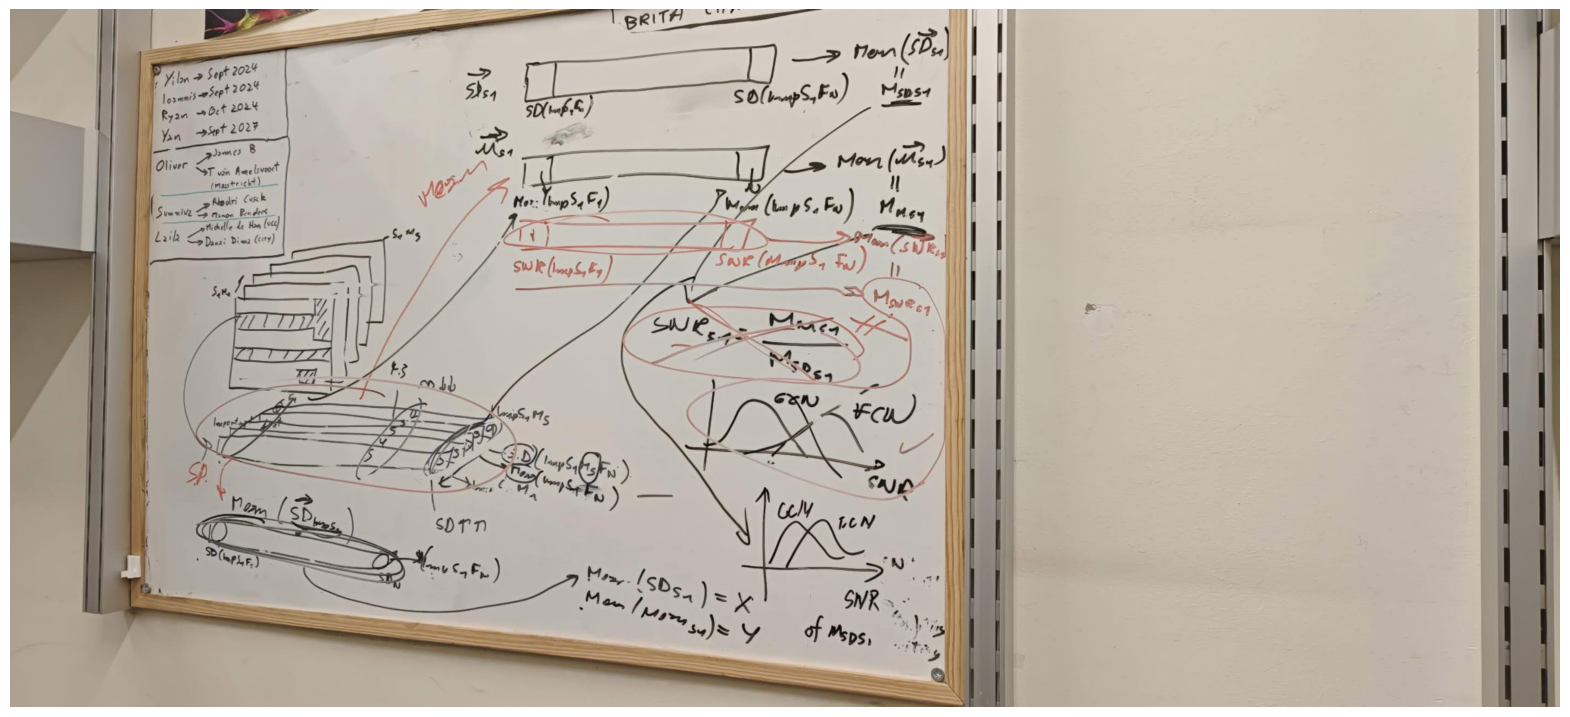

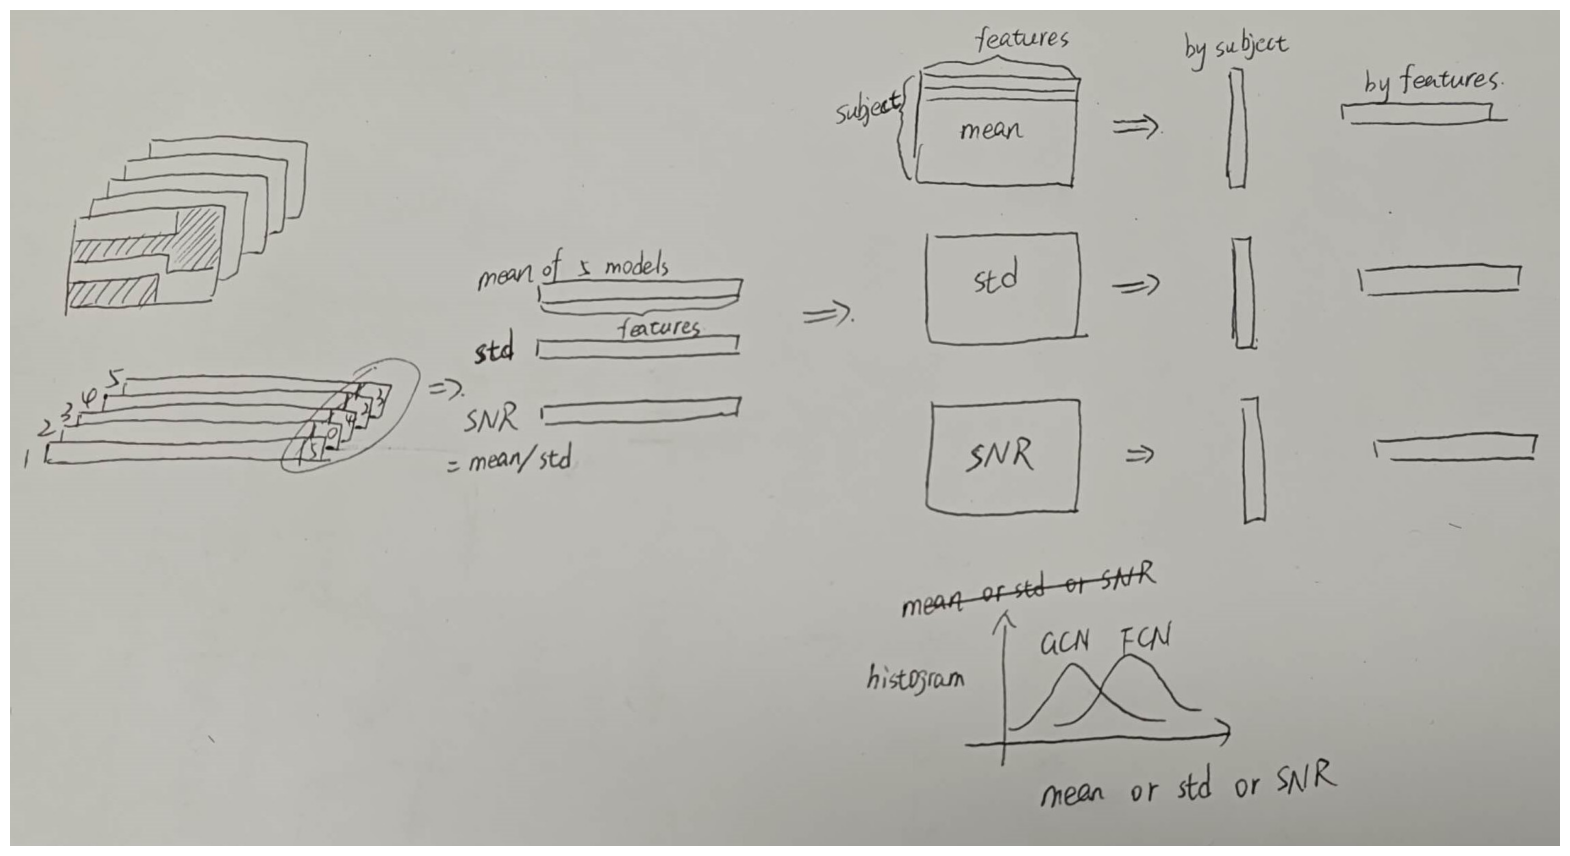

In [ ]:
from PIL import Image


image_path = '/content/drive/MyDrive/ABIDE/test_save_selected_features/stability_1.jpg'
image_path_2 = '/content/drive/MyDrive/ABIDE/test_save_selected_features/stability_2.jpg'


image = Image.open(image_path)
image_2 = Image.open(image_path_2)

fig, ax = plt.subplots(figsize=(20, 20))

ax.imshow(image)
ax.axis('off')
plt.show()

fig1, ax1 = plt.subplots(figsize=(20, 20))
# 展示调整后的图片
ax1.imshow(image_2)
ax1.axis('off')
plt.show()

Load the 17400 saliency maps, this time we only focus on the smoothgrad saliency maps. For each subject, there are five models to ensemble their outputs, as a result, it has 5 smoothgrad saliency maps.

The first step is to find the important features in the rigid + REF feature selection step. The standard is: (try) show up half of the models (25/2=12.5 times). To achieve this:

1. Summary the selected features in 25 models.
2. Find out which features show up at least 13 times (this number can be changed)


1. Match them (4800) to 19900 + 1417 feature maps
2. ensemble the saliency maps, if intensity > 0, treat as one vote.


divide them into 4 interpretation groups, vanilla, guided, smoothgrad, guidedsmoothgrad.

We need to consider the different feature maps between the 5 different machine learning models in the inner loops. As a result, we need to match the 4800 features to the 19900 fMRI + 1417 sMRI feature maps. Then we can add the 5 saliency maps (inner models 1 to 5) of the same subject together

1. Match 4800 to 19900 fMRI + 1417 sMRI feature maps
2. So that we can add outputs of model 1~5 together

In [ ]:
labels_ensemble = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/ensemble_labels.npy',allow_pickle=True).item()
outputs_ensemble = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/ensemble_outputs.npy',allow_pickle=True).item()
sMRI_nested_features = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/sMRI_rigid_nested.npy',allow_pickle=True).item()
fMRI_nested_features = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/fMRI_rigid_nested.npy',allow_pickle=True).item()
dist_ensemble_test = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/dist_ensemble_test.npy',allow_pickle=True).item()
save_path = '/content/drive/MyDrive/ABIDE/test_save_selected_features/'
path_fcn_first = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/fcn_first_di_mean/'
path_fcn_second = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/fcn_second_di_mean/'
path_fcn_third = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/fcn_third_di_mean/'
path_gcn_first = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/gcn_first_di_mean/'
path_gcn_second = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/gcn_second_di_mean/'
path_gcn_third = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/gcn_third_di_mean/'
path_aefcn_first = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/aefcn_first_di_mean/'
path_aefcn_second = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/aefcn_second_di_mean/'
path_aefcn_third = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/aefcn_third_di_mean/'
path_evgcn_first = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/evgcn_first_di_mean/'
path_evgcn_second = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/evgcn_second_di_mean/'
path_evgcn_third = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/evgcn_third_di_mean/'

There are  182 subjects in the ensemble fold  1
The accuracy of this ensemble fold is  0.7582417582417582
There are  177 subjects in the ensemble fold  2
The accuracy of this ensemble fold is  0.7175141242937854
There are  174 subjects in the ensemble fold  3
The accuracy of this ensemble fold is  0.735632183908046
There are  170 subjects in the ensemble fold  4
The accuracy of this ensemble fold is  0.6705882352941176
There are  167 subjects in the ensemble fold  5
The accuracy of this ensemble fold is  0.7245508982035929


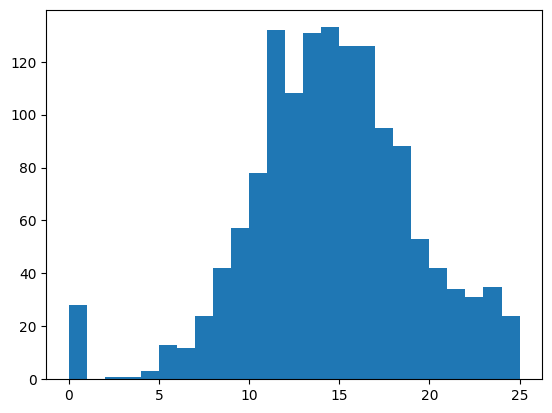

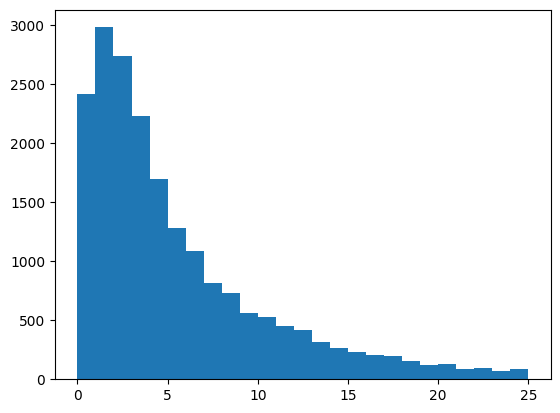

787
1645


In [ ]:
def match_feature_selection(all,saliency):
  all_numpy = np.array(all)
  feature_map = np.zeros((1,all_numpy.shape[0]))
  index_ = np.where(all_numpy==1)
  for i in range(len(index_[0])):
    feature_map[0,index_[0][i]]= saliency[i]
  return feature_map

all_smri_voting = np.zeros((1,1417))
all_fmri_voting = np.zeros((1,19900))

threshold_s = 13
threshold_f = 13

for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  labels = labels_ensemble[str(ensemble_fold+1)]
  test_outputs_ensemble = outputs_ensemble[str(ensemble_fold+1)]['1'] + outputs_ensemble[str(ensemble_fold+1)]['2'] + outputs_ensemble[str(ensemble_fold+1)]['3'] + outputs_ensemble[str(ensemble_fold+1)]['4'] + outputs_ensemble[str(ensemble_fold+1)]['5']
  test_results_binary = np.zeros_like((test_outputs_ensemble))
  test_results_binary[test_outputs_ensemble<2.5] = 0
  test_results_binary[test_outputs_ensemble>=2.5] = 1
  test_accuracy = metrics.accuracy_score(labels, test_results_binary)
  print('There are ',test_results_binary.shape[0], 'subjects in the ensemble fold ', str(ensemble_fold+1))
  print('The accuracy of this ensemble fold is ',test_accuracy)

  for fold in range(1, k_fold+1):
    smri_ranking = sMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
    fmri_ranking = fMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
    index_s = np.where(smri_ranking==1)[0]
    index_f = np.where(fmri_ranking==1)[0]
    # print(index_s)
    all_smri_voting[0,index_s] = all_smri_voting[0,index_s] + 1
    all_fmri_voting[0,index_f] = all_fmri_voting[0,index_f] + 1
    # print(len(np.where(smri_ranking==1)[0]))
    # print(len(np.where(fmri_ranking==1)[0]))

plt.hist(all_smri_voting.flatten(), bins=25)
plt.show()
plt.hist(all_fmri_voting.flatten(), bins=25)
plt.show()

index_s = np.where(all_smri_voting>threshold_s)
index_f = np.where(all_fmri_voting>threshold_f)
print(len(index_s[1]))
print(len(index_f[1]))



**Check!**

In [ ]:
print(index_f)
print(len(index_f[1]))
# print(index_s)
print(len(index_s[1]))
print(len(index_f[1]) + len(index_s[1]))

(array([0, 0, 0, ..., 0, 0, 0]), array([    9,    42,    50, ..., 19868, 19869, 19872]))
1645
787
2432


Check! AE-FCN  saliency map zeros issue

In [ ]:
check_path = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/aefcn_third/'

number = 0

for i in range(870):
  print(i)
  for j in range(1,6):
    name = str(i) + '_' + str(j) + '_smooth.mat'
    smooth = scio.loadmat(os.path.join(check_path, name))
    smooth = smooth['saliency']
    std = np.std(smooth)
    if std == 0:
      number = number + 1
      print(name)
print(number)


0
1
2
3
4
5
6
7
8
9
10
10_5_smooth.mat
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
39_5_smooth.mat
40
41
42
43
44
45
45_5_smooth.mat
46
47
48
49
50
51
52
52_5_smooth.mat
53
54
55
56
57
58
59
60
60_5_smooth.mat
61
62
63
64
65
66
66_5_smooth.mat
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
115_5_smooth.mat
116
117
118
118_1_smooth.mat
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
139_5_smooth.mat
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
156_5_smooth.mat
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
23

## Calculate the mean SNR for each subject

The second step is to

1. take these features' saliency intensity out of the maps.

For each subject, in total five lines' saliency values,
2. calculate the mean and std for each features
3. calculate the mean of the mean and mean of the std, so that we obtain the SNR = mean/std for this subject
4. obtain the SNR for all the 870 subjects, plot the fcn SNR histgram.


**!!!!!  We have FCN first, second, third training processes, the SNR should be the average of these three processes**

## FCN first

The 1  subject is  828


<ipython-input-14-1cdc01518ba5>:49: RuntimeWarning: invalid value encountered in divide
  snrs = means/stds


1.4099117702936184
The 2  subject is  835
1.4168466855480264
The 3  subject is  838
1.3531326770683045
The 4  subject is  393
1.4207461418577274
The 5  subject is  395
1.4375910198028587
The 6  subject is  400
1.3636699411264614
The 7  subject is  461
1.429261234055913
The 8  subject is  468
1.4159082294505225
The 9  subject is  469
1.4536492904548841
The 10  subject is  476
1.4499393767911068
The 11  subject is  480
1.3744331879941158
The 12  subject is  485
1.3843958821553277
The 13  subject is  486
1.4028452046988338
The 14  subject is  407
1.414852108151711
The 15  subject is  408
1.4180403178365872
The 16  subject is  414
1.4398369916017422
The 17  subject is  417
1.4152920805039155
The 18  subject is  423
1.4251162321261892
The 19  subject is  425
1.41977353812776
The 20  subject is  430
1.4344891702781626
The 21  subject is  436
1.372749497824888
The 22  subject is  442
1.3390789682089048
The 23  subject is  443
1.39691447947193
The 24  subject is  452
1.4234507906124343
The 25 

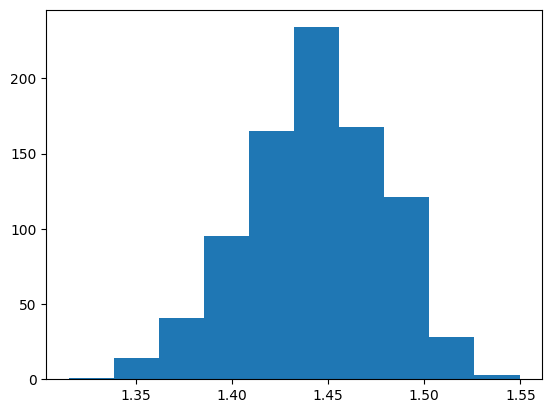

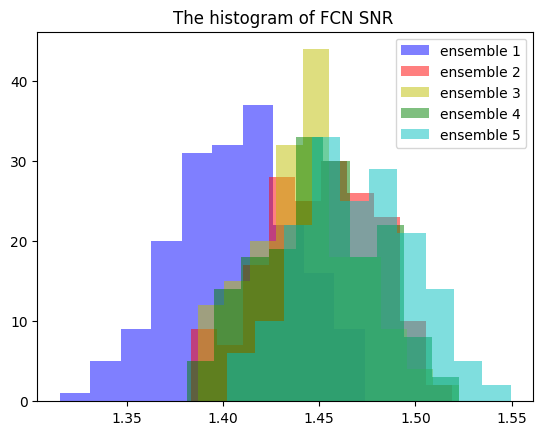

In [ ]:
SNR_fcn_first = []
total_number = 0


check_ensemble_1 = []
check_ensemble_2 = []
check_ensemble_3 = []
check_ensemble_4 = []
check_ensemble_5 = []

fcn_subject_mean_first = np.zeros((870,len(index_f[1]) + len(index_s[1])))
fcn_subject_std_first = np.zeros((870,len(index_f[1]) + len(index_s[1])))
fcn_subject_snr_first = np.zeros((870,len(index_f[1]) + len(index_s[1])))

for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  for i in range(len(test_index)):
    total_number = total_number + 1
    each_subject = test_index[i]
    print('The', total_number,' subject is ',each_subject)
    f_selected_features = np.zeros((k_fold,19900))
    s_selected_features = np.zeros((k_fold,1417))
    for fold in range(1, k_fold+1):

      smri_ranking = sMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
      fmri_ranking = fMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]

      smooth_name = str(each_subject)+'_'+str(fold)+'_smooth.mat'
      smooth = scio.loadmat(os.path.join(path_fcn_first, smooth_name))
      smooth = smooth['saliency']
      fmri = smooth[0,0:4000]
      smri = smooth[0,4000:]
      smri_feature_map = match_feature_selection(smri_ranking,smri)
      fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      s_selected_features[fold-1,index_s[1]] = smri_feature_map[0,index_s[1]]+0
      f_selected_features[fold-1,index_f[1]] = fmri_feature_map[0,index_f[1]]+0
      # print(s_selected_features[fold-1,index_s[0]].shape)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # print(fmri_feature_map.shape)
      # print(total_feature_map)
      # total_smooth = total_smooth + total_feature_map
    new_s_selected_features = s_selected_features[:,index_s[1]]
    new_f_selected_features = f_selected_features[:,index_f[1]]
    new_fs_features_map = np.concatenate((new_f_selected_features,new_s_selected_features),axis=1)
    means = np.mean(new_fs_features_map,axis=0)
    fcn_subject_mean_first[each_subject,:] = means + 0
    stds = np.std(new_fs_features_map,axis=0)
    fcn_subject_std_first[each_subject,:] = stds + 0
    snrs = means/stds
    nan_indices = np.where(np.isnan(snrs))
    # print(nan_indices)
    # print(len(nan_indices[0]))
    for index in nan_indices[0]:
      if means[index] == 0:
        snrs[index] = 0
      else:
        print('nan because of std ',stds[index])

    fcn_subject_snr_first[each_subject,:] = snrs + 0

    mean_snr = np.sum(snrs,axis=0) / snrs.shape[0]
    SNR_fcn_first.append(mean_snr)
    print(mean_snr)



    if ensemble_fold == 0:
      check_ensemble_1.append(mean_snr)
    if ensemble_fold == 1:
      check_ensemble_2.append(mean_snr)
    if ensemble_fold == 2:
      check_ensemble_3.append(mean_snr)
    if ensemble_fold == 3:
      check_ensemble_4.append(mean_snr)
    if ensemble_fold == 4:
      check_ensemble_5.append(mean_snr)


plt.hist(SNR_fcn_first,bins=10)
plt.show()

plt.hist(check_ensemble_1,alpha=0.5, color='b',label='ensemble 1')
plt.hist(check_ensemble_2,alpha=0.5, color='r',label='ensemble 2')
plt.hist(check_ensemble_3,alpha=0.5, color='y',label='ensemble 3')
plt.hist(check_ensemble_4,alpha=0.5, color='g',label='ensemble 4')
plt.hist(check_ensemble_5,alpha=0.5, color='c',label='ensemble 5')
plt.legend()
plt.title('The histogram of FCN SNR ')
plt.show()


scio.savemat(save_path+'fcn_snr_first.mat',{'snr':np.array(SNR_fcn_first)})
scio.savemat(save_path+'fcn_snr_first_1.mat',{'snr':np.array(check_ensemble_1)})
scio.savemat(save_path+'fcn_snr_first_2.mat',{'snr':np.array(check_ensemble_2)})
scio.savemat(save_path+'fcn_snr_first_3.mat',{'snr':np.array(check_ensemble_3)})
scio.savemat(save_path+'fcn_snr_first_4.mat',{'snr':np.array(check_ensemble_4)})
scio.savemat(save_path+'fcn_snr_first_5.mat',{'snr':np.array(check_ensemble_5)})

## FCN second

The 1  subject is  828


<ipython-input-15-37b4fd555d20>:49: RuntimeWarning: invalid value encountered in divide
  snrs = means/stds


1.1725348054452756
The 2  subject is  835
1.1717619997191235
The 3  subject is  838
1.1891717770423218
The 4  subject is  393
1.2652467196973436
The 5  subject is  395
1.2901075034030824
The 6  subject is  400
1.130777340844493
The 7  subject is  461
1.2907360013570968
The 8  subject is  468
1.2028743570969471
The 9  subject is  469
1.2658498945431917
The 10  subject is  476
1.235249337166969
The 11  subject is  480
1.2022873046333757
The 12  subject is  485
1.2130697269612314
The 13  subject is  486
1.2288784296772415
The 14  subject is  407
1.1854534275540463
The 15  subject is  408
1.2320650553371078
The 16  subject is  414
1.2556668027007891
The 17  subject is  417
1.2312218260301584
The 18  subject is  423
1.2266582399112844
The 19  subject is  425
1.2105797889128578
The 20  subject is  430
1.242280642476378
The 21  subject is  436
1.1347863429305836
The 22  subject is  442
1.1398961529992764
The 23  subject is  443
1.2269799509074744
The 24  subject is  452
1.2016760328456586
The

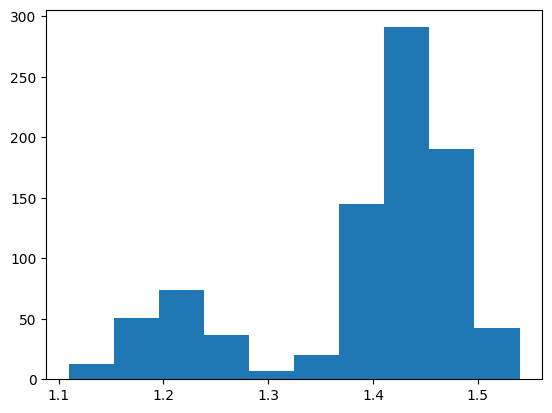

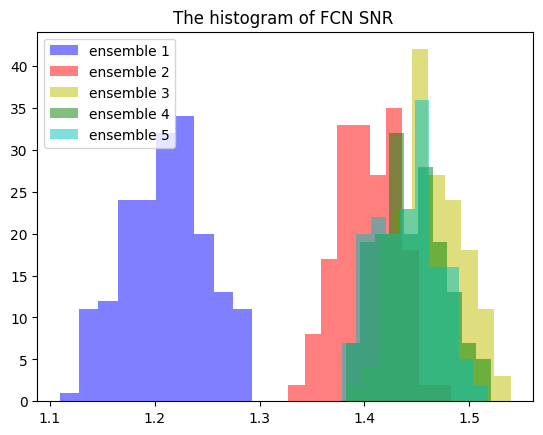

In [ ]:
SNR_fcn_second = []
total_number = 0

check_ensemble_1 = []
check_ensemble_2 = []
check_ensemble_3 = []
check_ensemble_4 = []
check_ensemble_5 = []


fcn_subject_mean_second = np.zeros((870,len(index_f[1]) + len(index_s[1])))
fcn_subject_std_second = np.zeros((870,len(index_f[1]) + len(index_s[1])))
fcn_subject_snr_second = np.zeros((870,len(index_f[1]) + len(index_s[1])))

for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  for i in range(len(test_index)):
    total_number = total_number + 1
    each_subject = test_index[i]
    print('The', total_number,' subject is ',each_subject)
    f_selected_features = np.zeros((k_fold,19900))
    s_selected_features = np.zeros((k_fold,1417))
    for fold in range(1, k_fold+1):

      smri_ranking = sMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
      fmri_ranking = fMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]

      smooth_name = str(each_subject)+'_'+str(fold)+'_smooth.mat'
      smooth = scio.loadmat(os.path.join(path_fcn_second, smooth_name))
      smooth = smooth['saliency']
      fmri = smooth[0,0:4000]
      smri = smooth[0,4000:]
      smri_feature_map = match_feature_selection(smri_ranking,smri)
      fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      s_selected_features[fold-1,index_s[1]] = smri_feature_map[0,index_s[1]]+0
      f_selected_features[fold-1,index_f[1]] = fmri_feature_map[0,index_f[1]]+0
      # print(s_selected_features[fold-1,index_s[0]].shape)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # print(fmri_feature_map.shape)
      # print(total_feature_map)
      # total_smooth = total_smooth + total_feature_map
    new_s_selected_features = s_selected_features[:,index_s[1]]
    new_f_selected_features = f_selected_features[:,index_f[1]]
    new_fs_features_map = np.concatenate((new_f_selected_features,new_s_selected_features),axis=1)
    means = np.mean(new_fs_features_map,axis=0)
    fcn_subject_mean_second[each_subject,:] = means + 0
    stds = np.std(new_fs_features_map,axis=0)
    fcn_subject_std_second[each_subject,:] = stds + 0
    snrs = means/stds
    nan_indices = np.where(np.isnan(snrs))
    # print(nan_indices)
    # print(len(nan_indices[0]))
    for index in nan_indices[0]:
      if means[index] == 0:
        snrs[index] = 0
      else:
        print('nan because of std ',stds[index])

    fcn_subject_snr_second[each_subject,:] = snrs + 0

    mean_snr = np.sum(snrs,axis=0) / snrs.shape[0]
    SNR_fcn_second.append(mean_snr)
    print(mean_snr)

    if ensemble_fold == 0:
      check_ensemble_1.append(mean_snr)
    if ensemble_fold == 1:
      check_ensemble_2.append(mean_snr)
    if ensemble_fold == 2:
      check_ensemble_3.append(mean_snr)
    if ensemble_fold == 3:
      check_ensemble_4.append(mean_snr)
    if ensemble_fold == 4:
      check_ensemble_5.append(mean_snr)

plt.hist(SNR_fcn_second,bins=10)
plt.show()

plt.hist(check_ensemble_1,alpha=0.5, color='b',label='ensemble 1')
plt.hist(check_ensemble_2,alpha=0.5, color='r',label='ensemble 2')
plt.hist(check_ensemble_3,alpha=0.5, color='y',label='ensemble 3')
plt.hist(check_ensemble_4,alpha=0.5, color='g',label='ensemble 4')
plt.hist(check_ensemble_5,alpha=0.5, color='c',label='ensemble 5')
plt.legend()
plt.title('The histogram of FCN SNR ')
plt.show()

scio.savemat(save_path+'fcn_snr_second.mat',{'snr':np.array(SNR_fcn_second)})
scio.savemat(save_path+'fcn_snr_second_1.mat',{'snr':np.array(check_ensemble_1)})
scio.savemat(save_path+'fcn_snr_second_2.mat',{'snr':np.array(check_ensemble_2)})
scio.savemat(save_path+'fcn_snr_second_3.mat',{'snr':np.array(check_ensemble_3)})
scio.savemat(save_path+'fcn_snr_second_4.mat',{'snr':np.array(check_ensemble_4)})
scio.savemat(save_path+'fcn_snr_second_5.mat',{'snr':np.array(check_ensemble_5)})

## FCN third

The 1  subject is  828


<ipython-input-16-567e1a0a3de2>:48: RuntimeWarning: invalid value encountered in divide
  snrs = means/stds


1.4251223151283758
The 2  subject is  835
1.4143870732475414
The 3  subject is  838
1.410769705270815
The 4  subject is  393
1.4465979891338283
The 5  subject is  395
1.4203785465214254
The 6  subject is  400
1.361780174819065
The 7  subject is  461
1.4813926506421073
The 8  subject is  468
1.4148693236927083
The 9  subject is  469
1.4597009776838945
The 10  subject is  476
1.4576722504206883
The 11  subject is  480
1.3731164331755215
The 12  subject is  485
1.41286332203396
The 13  subject is  486
1.4325636434056785
The 14  subject is  407
1.4276367310322224
The 15  subject is  408
1.4397955387467416
The 16  subject is  414
1.4268519348537987
The 17  subject is  417
1.447637213685413
The 18  subject is  423
1.4286678005182096
The 19  subject is  425
1.4399258155289896
The 20  subject is  430
1.4345703497724827
The 21  subject is  436
1.4085142915116127
The 22  subject is  442
1.3761076700554096
The 23  subject is  443
1.448861648030857
The 24  subject is  452
1.4254587779843806
The 25

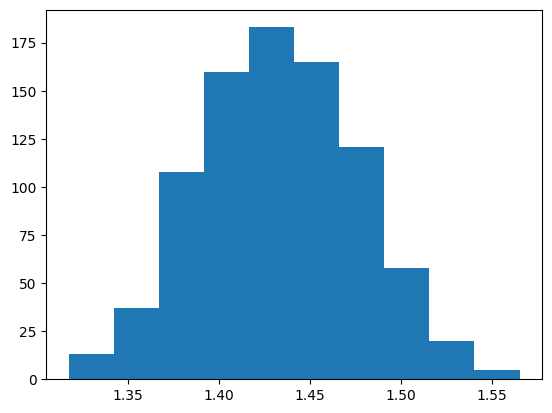

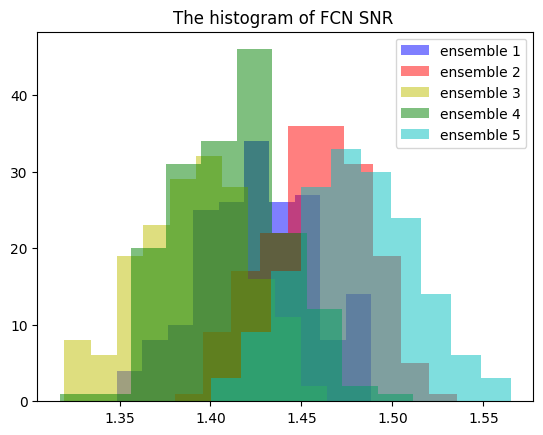

In [ ]:
SNR_fcn_third = []
total_number = 0

check_ensemble_1 = []
check_ensemble_2 = []
check_ensemble_3 = []
check_ensemble_4 = []
check_ensemble_5 = []

fcn_subject_mean_third = np.zeros((870,len(index_f[1]) + len(index_s[1])))
fcn_subject_std_third = np.zeros((870,len(index_f[1]) + len(index_s[1])))
fcn_subject_snr_third = np.zeros((870,len(index_f[1]) + len(index_s[1])))

for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  for i in range(len(test_index)):
    total_number = total_number + 1
    each_subject = test_index[i]
    print('The', total_number,' subject is ',each_subject)
    f_selected_features = np.zeros((k_fold,19900))
    s_selected_features = np.zeros((k_fold,1417))
    for fold in range(1, k_fold+1):

      smri_ranking = sMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
      fmri_ranking = fMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]

      smooth_name = str(each_subject)+'_'+str(fold)+'_smooth.mat'
      smooth = scio.loadmat(os.path.join(path_fcn_third, smooth_name))
      smooth = smooth['saliency']
      fmri = smooth[0,0:4000]
      smri = smooth[0,4000:]
      smri_feature_map = match_feature_selection(smri_ranking,smri)
      fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      s_selected_features[fold-1,index_s[1]] = smri_feature_map[0,index_s[1]]+0
      f_selected_features[fold-1,index_f[1]] = fmri_feature_map[0,index_f[1]]+0
      # print(s_selected_features[fold-1,index_s[0]].shape)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # print(fmri_feature_map.shape)
      # print(total_feature_map)
      # total_smooth = total_smooth + total_feature_map
    new_s_selected_features = s_selected_features[:,index_s[1]]
    new_f_selected_features = f_selected_features[:,index_f[1]]
    new_fs_features_map = np.concatenate((new_f_selected_features,new_s_selected_features),axis=1)
    means = np.mean(new_fs_features_map,axis=0)
    fcn_subject_mean_third[each_subject,:] = means + 0
    stds = np.std(new_fs_features_map,axis=0)
    fcn_subject_std_third[each_subject,:] = stds + 0
    snrs = means/stds
    nan_indices = np.where(np.isnan(snrs))
    # print(nan_indices)
    # print(len(nan_indices[0]))
    for index in nan_indices[0]:
      if means[index] == 0:
        snrs[index] = 0
      else:
        print('nan because of std ',stds[index])

    fcn_subject_snr_third[each_subject,:] = snrs + 0

    mean_snr = np.sum(snrs,axis=0) / snrs.shape[0]
    SNR_fcn_third.append(mean_snr)
    print(mean_snr)

    if ensemble_fold == 0:
      check_ensemble_1.append(mean_snr)
    if ensemble_fold == 1:
      check_ensemble_2.append(mean_snr)
    if ensemble_fold == 2:
      check_ensemble_3.append(mean_snr)
    if ensemble_fold == 3:
      check_ensemble_4.append(mean_snr)
    if ensemble_fold == 4:
      check_ensemble_5.append(mean_snr)



plt.hist(SNR_fcn_third,bins=10)
plt.show()

plt.hist(check_ensemble_1,alpha=0.5, color='b',label='ensemble 1')
plt.hist(check_ensemble_2,alpha=0.5, color='r',label='ensemble 2')
plt.hist(check_ensemble_3,alpha=0.5, color='y',label='ensemble 3')
plt.hist(check_ensemble_4,alpha=0.5, color='g',label='ensemble 4')
plt.hist(check_ensemble_5,alpha=0.5, color='c',label='ensemble 5')
plt.legend()
plt.title('The histogram of FCN SNR ')
plt.show()

scio.savemat(save_path+'fcn_snr_third.mat',{'snr':np.array(SNR_fcn_third)})
scio.savemat(save_path+'fcn_snr_third_1.mat',{'snr':np.array(check_ensemble_1)})
scio.savemat(save_path+'fcn_snr_third_2.mat',{'snr':np.array(check_ensemble_2)})
scio.savemat(save_path+'fcn_snr_third_3.mat',{'snr':np.array(check_ensemble_3)})
scio.savemat(save_path+'fcn_snr_third_4.mat',{'snr':np.array(check_ensemble_4)})
scio.savemat(save_path+'fcn_snr_third_5.mat',{'snr':np.array(check_ensemble_5)})

summary the first, second, third FCN snr

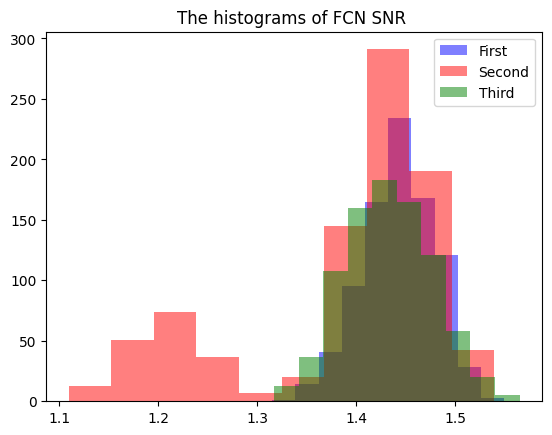

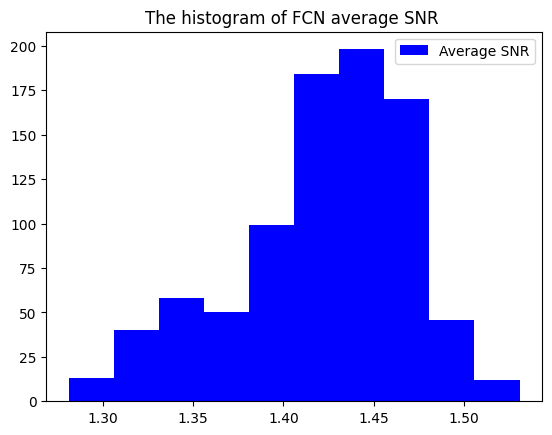

In [ ]:
plt.hist(SNR_fcn_first,alpha=0.5, color='b',label='First')
plt.hist(SNR_fcn_second,alpha=0.5, color='r',label='Second')
plt.hist(SNR_fcn_third,alpha=0.5, color='g',label='Third')
plt.legend()
plt.title('The histograms of FCN SNR ')
plt.show()

array_fcn_first = np.array(SNR_fcn_first)
array_fcn_second = np.array(SNR_fcn_second)
array_fcn_third = np.array(SNR_fcn_third)
fcn_average_snr = list((array_fcn_first + array_fcn_second + array_fcn_third)/3)

plt.hist(fcn_average_snr, color='b',label='Average SNR')
plt.legend()
plt.title('The histogram of FCN average SNR ')
plt.show()

## GCN first

The 1  subject is  828


<ipython-input-18-53ef70617154>:49: RuntimeWarning: invalid value encountered in divide
  snrs = means/stds


1.4102111113996803
The 2  subject is  835
1.3676309308379009
The 3  subject is  838
1.386652779275571
The 4  subject is  393
1.4676907828237091
The 5  subject is  395
1.4652358551744356
The 6  subject is  400
1.3371224043067116
The 7  subject is  461
1.4462004538727673
The 8  subject is  468
1.416189306156333
The 9  subject is  469
1.4189763132538626
The 10  subject is  476
1.437503819146049
The 11  subject is  480
1.4395464733479344
The 12  subject is  485
1.37294264684304
The 13  subject is  486
1.3953310005197852
The 14  subject is  407
1.3945008497376061
The 15  subject is  408
1.4688390820364319
The 16  subject is  414
1.448870530381782
The 17  subject is  417
1.4444207214384992
The 18  subject is  423
1.4556302977721176
The 19  subject is  425
1.4539740937896404
The 20  subject is  430
1.455779942832472
The 21  subject is  436
1.4055296584537862
The 22  subject is  442
1.2965008000536526
The 23  subject is  443
1.4570860922280287
The 24  subject is  452
1.45705777165886
The 25  s

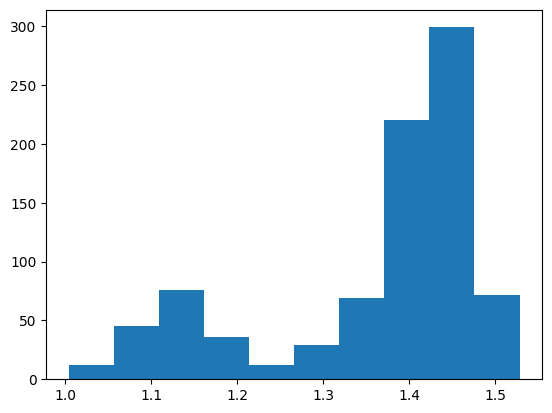

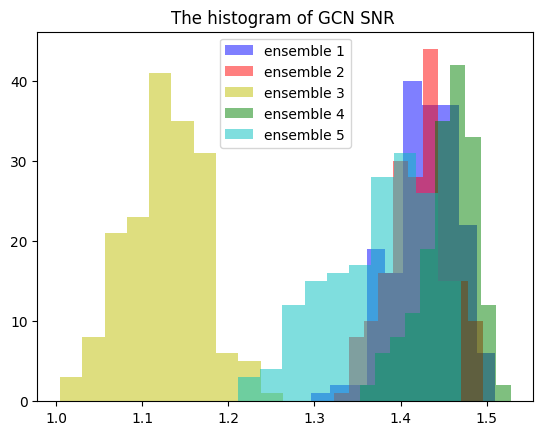

In [ ]:

SNR_gcn_first = []
total_number = 0

check_ensemble_1 = []
check_ensemble_2 = []
check_ensemble_3 = []
check_ensemble_4 = []
check_ensemble_5 = []


gcn_subject_mean_first = np.zeros((870,len(index_f[1]) + len(index_s[1])))
gcn_subject_std_first = np.zeros((870,len(index_f[1]) + len(index_s[1])))
gcn_subject_snr_first = np.zeros((870,len(index_f[1]) + len(index_s[1])))

for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  for i in range(len(test_index)):
    total_number = total_number + 1
    each_subject = test_index[i]
    print('The', total_number,' subject is ',each_subject)
    f_selected_features = np.zeros((k_fold,19900))
    s_selected_features = np.zeros((k_fold,1417))
    for fold in range(1, k_fold+1):

      smri_ranking = sMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
      fmri_ranking = fMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]

      smooth_name = str(each_subject)+'_'+str(fold)+'_smooth.mat'
      smooth = scio.loadmat(os.path.join(path_gcn_first, smooth_name))
      smooth = smooth['saliency']
      fmri = smooth[0,0:4000]
      smri = smooth[0,4000:]
      smri_feature_map = match_feature_selection(smri_ranking,smri)
      fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      s_selected_features[fold-1,index_s[1]] = smri_feature_map[0,index_s[1]]+0
      f_selected_features[fold-1,index_f[1]] = fmri_feature_map[0,index_f[1]]+0
      # print(s_selected_features[fold-1,index_s[0]].shape)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # print(fmri_feature_map.shape)
      # print(total_feature_map)
      # total_smooth = total_smooth + total_feature_map
    new_s_selected_features = s_selected_features[:,index_s[1]]
    new_f_selected_features = f_selected_features[:,index_f[1]]
    new_fs_features_map = np.concatenate((new_f_selected_features,new_s_selected_features),axis=1)
    means = np.mean(new_fs_features_map,axis=0)
    gcn_subject_mean_first[each_subject,:] = means + 0
    stds = np.std(new_fs_features_map,axis=0)
    gcn_subject_std_first[each_subject,:] = stds + 0
    snrs = means/stds
    nan_indices = np.where(np.isnan(snrs))
    # print(nan_indices)
    # print(len(nan_indices[0]))
    for index in nan_indices[0]:
      if means[index] == 0:
        snrs[index] = 0
      else:
        print('nan because of std ',stds[index])

    gcn_subject_snr_first[each_subject,:] = snrs + 0

    indices_0 = np.where(snrs!=0)
    # print(indices_0[0])
    mean_snr = np.sum(snrs,axis=0) / len(indices_0[0])
    SNR_gcn_first.append(mean_snr)
    print(mean_snr)
    # print(len(nan_indices[0]))
    if ensemble_fold == 0:
      check_ensemble_1.append(mean_snr)
    if ensemble_fold == 1:
      check_ensemble_2.append(mean_snr)
    if ensemble_fold == 2:
      check_ensemble_3.append(mean_snr)
    if ensemble_fold == 3:
      check_ensemble_4.append(mean_snr)
    if ensemble_fold == 4:
      check_ensemble_5.append(mean_snr)


plt.hist(SNR_gcn_first,bins=10)
plt.show()

plt.hist(check_ensemble_1,alpha=0.5, color='b',label='ensemble 1')
plt.hist(check_ensemble_2,alpha=0.5, color='r',label='ensemble 2')
plt.hist(check_ensemble_3,alpha=0.5, color='y',label='ensemble 3')
plt.hist(check_ensemble_4,alpha=0.5, color='g',label='ensemble 4')
plt.hist(check_ensemble_5,alpha=0.5, color='c',label='ensemble 5')
plt.legend()
plt.title('The histogram of GCN SNR ')
plt.show()

scio.savemat(save_path+'gcn_snr_first.mat',{'snr':np.array(SNR_gcn_first)})
scio.savemat(save_path+'gcn_snr_first_1.mat',{'snr':np.array(check_ensemble_1)})
scio.savemat(save_path+'gcn_snr_first_2.mat',{'snr':np.array(check_ensemble_2)})
scio.savemat(save_path+'gcn_snr_first_3.mat',{'snr':np.array(check_ensemble_3)})
scio.savemat(save_path+'gcn_snr_first_4.mat',{'snr':np.array(check_ensemble_4)})
scio.savemat(save_path+'gcn_snr_first_5.mat',{'snr':np.array(check_ensemble_5)})

## GCN second

The 1  subject is  828


<ipython-input-19-e608344679a6>:49: RuntimeWarning: invalid value encountered in divide
  snrs = means/stds


1.1430664416742877
The 2  subject is  835
1.137654603948001
The 3  subject is  838
1.1185664818134418
The 4  subject is  393
1.1568991532269715
The 5  subject is  395
1.2055990804000587
The 6  subject is  400
1.0945271919735324
The 7  subject is  461
1.199894761143429
The 8  subject is  468
1.1154080960349548
The 9  subject is  469
1.1576340952287858
The 10  subject is  476
1.1044601824048244
The 11  subject is  480
1.10323857140928
The 12  subject is  485
1.0878616246009205
The 13  subject is  486
1.1026327616563323
The 14  subject is  407
1.1284666120018294
The 15  subject is  408
1.194433544667677
The 16  subject is  414
1.1776528305551706
The 17  subject is  417
1.1778358146983359
The 18  subject is  423
1.1597847649561261
The 19  subject is  425
1.1645483543140938
The 20  subject is  430
1.1394761692700708
The 21  subject is  436
1.1268798745368753
The 22  subject is  442
1.0738552187279669
The 23  subject is  443
1.1627022707991237
The 24  subject is  452
1.1791572636299548
The 2

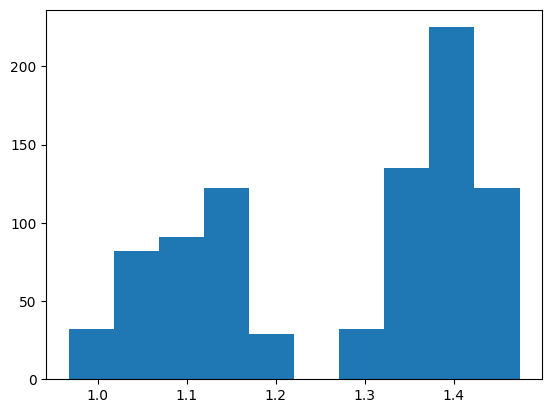

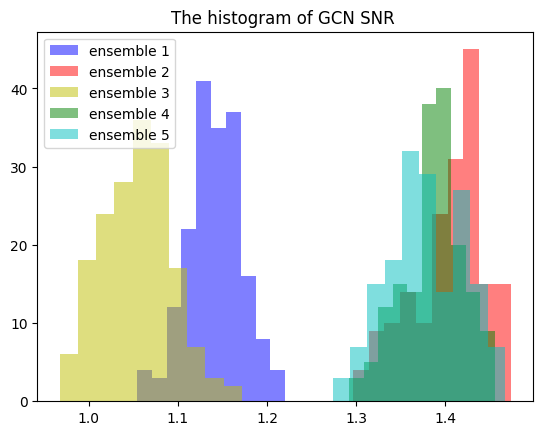

In [ ]:

SNR_gcn_second = []
total_number = 0

check_ensemble_1 = []
check_ensemble_2 = []
check_ensemble_3 = []
check_ensemble_4 = []
check_ensemble_5 = []


gcn_subject_mean_second = np.zeros((870,len(index_f[1]) + len(index_s[1])))
gcn_subject_std_second = np.zeros((870,len(index_f[1]) + len(index_s[1])))
gcn_subject_snr_second = np.zeros((870,len(index_f[1]) + len(index_s[1])))

for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  for i in range(len(test_index)):
    total_number = total_number + 1
    each_subject = test_index[i]
    print('The', total_number,' subject is ',each_subject)
    f_selected_features = np.zeros((k_fold,19900))
    s_selected_features = np.zeros((k_fold,1417))
    for fold in range(1, k_fold+1):

      smri_ranking = sMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
      fmri_ranking = fMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]

      smooth_name = str(each_subject)+'_'+str(fold)+'_smooth.mat'
      smooth = scio.loadmat(os.path.join(path_gcn_second, smooth_name))
      smooth = smooth['saliency']
      fmri = smooth[0,0:4000]
      smri = smooth[0,4000:]
      smri_feature_map = match_feature_selection(smri_ranking,smri)
      fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      s_selected_features[fold-1,index_s[1]] = smri_feature_map[0,index_s[1]]+0
      f_selected_features[fold-1,index_f[1]] = fmri_feature_map[0,index_f[1]]+0
      # print(s_selected_features[fold-1,index_s[0]].shape)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # print(fmri_feature_map.shape)
      # print(total_feature_map)
      # total_smooth = total_smooth + total_feature_map
    new_s_selected_features = s_selected_features[:,index_s[1]]
    new_f_selected_features = f_selected_features[:,index_f[1]]
    new_fs_features_map = np.concatenate((new_f_selected_features,new_s_selected_features),axis=1)
    means = np.mean(new_fs_features_map,axis=0)
    gcn_subject_mean_second[each_subject,:] = means + 0
    stds = np.std(new_fs_features_map,axis=0)
    gcn_subject_std_second[each_subject,:] = stds + 0
    snrs = means/stds
    nan_indices = np.where(np.isnan(snrs))
    # print(nan_indices)
    # print(len(nan_indices[0]))
    for index in nan_indices[0]:
      if means[index] == 0:
        snrs[index] = 0
      else:
        print('nan because of std ',stds[index])

    gcn_subject_snr_second[each_subject,:] = snrs + 0

    indices_0 = np.where(snrs!=0)
    # print(indices_0[0])
    mean_snr = np.sum(snrs,axis=0) / len(indices_0[0])
    SNR_gcn_second.append(mean_snr)
    print(mean_snr)
    # print(len(nan_indices[0]))
    if ensemble_fold == 0:
      check_ensemble_1.append(mean_snr)
    if ensemble_fold == 1:
      check_ensemble_2.append(mean_snr)
    if ensemble_fold == 2:
      check_ensemble_3.append(mean_snr)
    if ensemble_fold == 3:
      check_ensemble_4.append(mean_snr)
    if ensemble_fold == 4:
      check_ensemble_5.append(mean_snr)


plt.hist(SNR_gcn_second,bins=10)
plt.show()

plt.hist(check_ensemble_1,alpha=0.5, color='b',label='ensemble 1')
plt.hist(check_ensemble_2,alpha=0.5, color='r',label='ensemble 2')
plt.hist(check_ensemble_3,alpha=0.5, color='y',label='ensemble 3')
plt.hist(check_ensemble_4,alpha=0.5, color='g',label='ensemble 4')
plt.hist(check_ensemble_5,alpha=0.5, color='c',label='ensemble 5')
plt.legend()
plt.title('The histogram of GCN SNR ')
plt.show()

scio.savemat(save_path+'gcn_snr_second.mat',{'snr':np.array(SNR_gcn_second)})
scio.savemat(save_path+'gcn_snr_second_1.mat',{'snr':np.array(check_ensemble_1)})
scio.savemat(save_path+'gcn_snr_second_2.mat',{'snr':np.array(check_ensemble_2)})
scio.savemat(save_path+'gcn_snr_second_3.mat',{'snr':np.array(check_ensemble_3)})
scio.savemat(save_path+'gcn_snr_second_4.mat',{'snr':np.array(check_ensemble_4)})
scio.savemat(save_path+'gcn_snr_second_5.mat',{'snr':np.array(check_ensemble_5)})

## GCN third

The 1  subject is  828


<ipython-input-20-d39bdddde18f>:49: RuntimeWarning: invalid value encountered in divide
  snrs = means/stds


1.273192191317223
The 2  subject is  835
1.275325451779123
The 3  subject is  838
1.2884829348899405
The 4  subject is  393
1.3352066389332595
The 5  subject is  395
1.2967200846710984
The 6  subject is  400
1.2506337870818258
The 7  subject is  461
1.3379667811922196
The 8  subject is  468
1.2999658814216508
The 9  subject is  469
1.3765384579529687
The 10  subject is  476
1.3589718865137206
The 11  subject is  480
1.3241692887161387
The 12  subject is  485
1.3350766386803605
The 13  subject is  486
1.2995843351967282
The 14  subject is  407
1.3090924028569204
The 15  subject is  408
1.3744418922967416
The 16  subject is  414
1.350222101371014
The 17  subject is  417
1.3343505998776215
The 18  subject is  423
1.363696501761406
The 19  subject is  425
1.3445451039458662
The 20  subject is  430
1.3509934680739808
The 21  subject is  436
1.3085391787821172
The 22  subject is  442
1.1471786841064462
The 23  subject is  443
1.3668099358418062
The 24  subject is  452
1.3250689039974928
The 

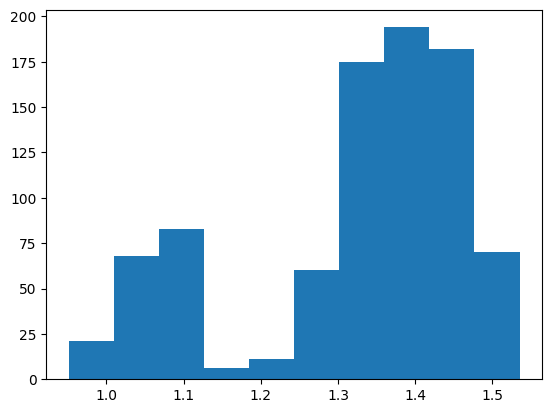

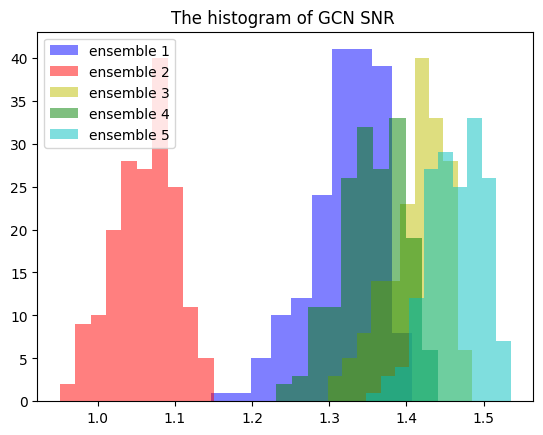

In [ ]:

SNR_gcn_third = []
total_number = 0

check_ensemble_1 = []
check_ensemble_2 = []
check_ensemble_3 = []
check_ensemble_4 = []
check_ensemble_5 = []


gcn_subject_mean_third = np.zeros((870,len(index_f[1]) + len(index_s[1])))
gcn_subject_std_third = np.zeros((870,len(index_f[1]) + len(index_s[1])))
gcn_subject_snr_third = np.zeros((870,len(index_f[1]) + len(index_s[1])))

for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  for i in range(len(test_index)):
    total_number = total_number + 1
    each_subject = test_index[i]
    print('The', total_number,' subject is ',each_subject)
    f_selected_features = np.zeros((k_fold,19900))
    s_selected_features = np.zeros((k_fold,1417))
    for fold in range(1, k_fold+1):

      smri_ranking = sMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
      fmri_ranking = fMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]

      smooth_name = str(each_subject)+'_'+str(fold)+'_smooth.mat'
      smooth = scio.loadmat(os.path.join(path_gcn_third, smooth_name))
      smooth = smooth['saliency']
      fmri = smooth[0,0:4000]
      smri = smooth[0,4000:]
      smri_feature_map = match_feature_selection(smri_ranking,smri)
      fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      s_selected_features[fold-1,index_s[1]] = smri_feature_map[0,index_s[1]]+0
      f_selected_features[fold-1,index_f[1]] = fmri_feature_map[0,index_f[1]]+0
      # print(s_selected_features[fold-1,index_s[0]].shape)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # print(fmri_feature_map.shape)
      # print(total_feature_map)
      # total_smooth = total_smooth + total_feature_map
    new_s_selected_features = s_selected_features[:,index_s[1]]
    new_f_selected_features = f_selected_features[:,index_f[1]]
    new_fs_features_map = np.concatenate((new_f_selected_features,new_s_selected_features),axis=1)
    means = np.mean(new_fs_features_map,axis=0)
    gcn_subject_mean_third[each_subject,:] = means + 0
    stds = np.std(new_fs_features_map,axis=0)
    gcn_subject_std_third[each_subject,:] = stds + 0
    snrs = means/stds
    nan_indices = np.where(np.isnan(snrs))
    # print(nan_indices)
    # print(len(nan_indices[0]))
    for index in nan_indices[0]:
      if means[index] == 0:
        snrs[index] = 0
      else:
        print('nan because of std ',stds[index])

    gcn_subject_snr_third[each_subject,:] = snrs + 0

    indices_0 = np.where(snrs!=0)
    # print(indices_0[0])
    mean_snr = np.sum(snrs,axis=0) / len(indices_0[0])
    SNR_gcn_third.append(mean_snr)
    print(mean_snr)
    # print(len(nan_indices[0]))
    if ensemble_fold == 0:
      check_ensemble_1.append(mean_snr)
    if ensemble_fold == 1:
      check_ensemble_2.append(mean_snr)
    if ensemble_fold == 2:
      check_ensemble_3.append(mean_snr)
    if ensemble_fold == 3:
      check_ensemble_4.append(mean_snr)
    if ensemble_fold == 4:
      check_ensemble_5.append(mean_snr)


plt.hist(SNR_gcn_third,bins=10)
plt.show()

plt.hist(check_ensemble_1,alpha=0.5, color='b',label='ensemble 1')
plt.hist(check_ensemble_2,alpha=0.5, color='r',label='ensemble 2')
plt.hist(check_ensemble_3,alpha=0.5, color='y',label='ensemble 3')
plt.hist(check_ensemble_4,alpha=0.5, color='g',label='ensemble 4')
plt.hist(check_ensemble_5,alpha=0.5, color='c',label='ensemble 5')
plt.legend()
plt.title('The histogram of GCN SNR ')
plt.show()

scio.savemat(save_path+'gcn_snr_third.mat',{'snr':np.array(SNR_gcn_third)})
scio.savemat(save_path+'gcn_snr_third_1.mat',{'snr':np.array(check_ensemble_1)})
scio.savemat(save_path+'gcn_snr_third_2.mat',{'snr':np.array(check_ensemble_2)})
scio.savemat(save_path+'gcn_snr_third_3.mat',{'snr':np.array(check_ensemble_3)})
scio.savemat(save_path+'gcn_snr_third_4.mat',{'snr':np.array(check_ensemble_4)})
scio.savemat(save_path+'gcn_snr_third_5.mat',{'snr':np.array(check_ensemble_5)})

Summary GCN SNR

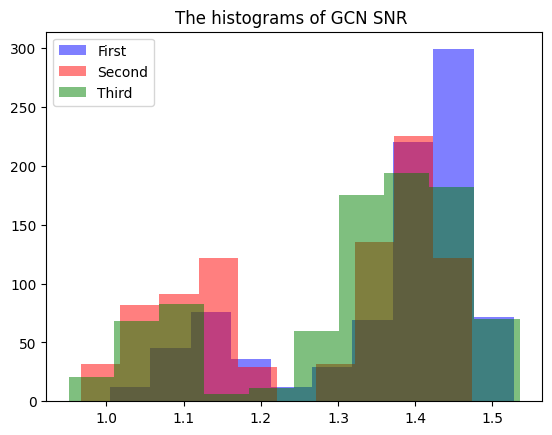

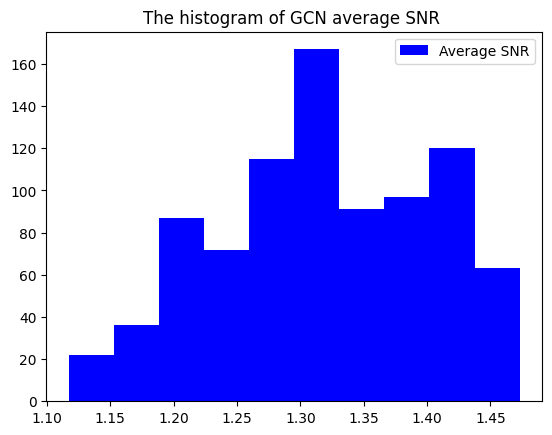

In [ ]:
plt.hist(SNR_gcn_first,alpha=0.5, color='b',label='First')
plt.hist(SNR_gcn_second,alpha=0.5, color='r',label='Second')
plt.hist(SNR_gcn_third,alpha=0.5, color='g',label='Third')
plt.legend()
plt.title('The histograms of GCN SNR ')
plt.show()

array_gcn_first = np.array(SNR_gcn_first)
array_gcn_second = np.array(SNR_gcn_second)
array_gcn_third = np.array(SNR_gcn_third)
gcn_average_snr = list((array_gcn_first + array_gcn_second + array_gcn_third)/3)

plt.hist(gcn_average_snr, color='b',label='Average SNR')
plt.legend()
plt.title('The histogram of GCN average SNR ')
plt.show()

## AE-FCN first

The 1  subject is  828


<ipython-input-14-fd974fde49d3>:49: RuntimeWarning: invalid value encountered in divide
  snrs = means/stds


1.2164230526945652
The 2  subject is  835
1.2201824206208804
The 3  subject is  838
1.237689711725131
The 4  subject is  393
1.2603083461730096
The 5  subject is  395
1.2492634151499686
The 6  subject is  400
1.230512423779137
The 7  subject is  461
1.2118408268509462
The 8  subject is  468
1.227951599868684
The 9  subject is  469
1.2378936828542237
The 10  subject is  476
1.2033326571284528
The 11  subject is  480
1.2493080807626173
The 12  subject is  485
1.2283145842337229
The 13  subject is  486
1.2244709690413451
The 14  subject is  407
1.2360447139088009
The 15  subject is  408
1.2399598456523442
The 16  subject is  414
1.2637075259581696
The 17  subject is  417
1.252338985320054
The 18  subject is  423
1.241617583071228
The 19  subject is  425
1.2288296069367781
The 20  subject is  430
1.2473151354236742
The 21  subject is  436
1.1775037720882775
The 22  subject is  442
1.1798921655156704
The 23  subject is  443
1.2635987091676744
The 24  subject is  452
1.236782122745387
The 25

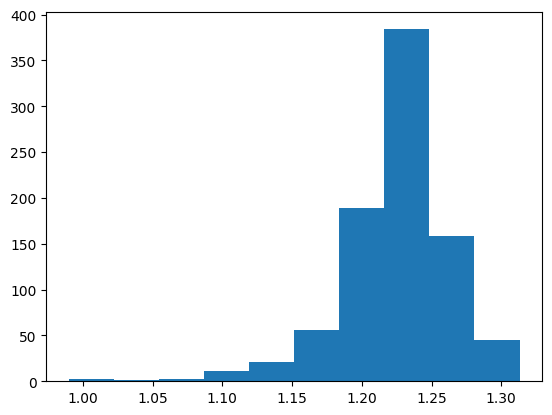

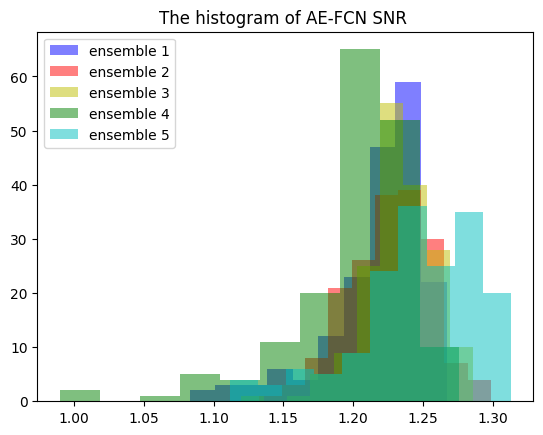

In [ ]:
SNR_aefcn_first = []
total_number = 0

check_ensemble_1 = []
check_ensemble_2 = []
check_ensemble_3 = []
check_ensemble_4 = []
check_ensemble_5 = []

aefcn_subject_mean_first = np.zeros((870,len(index_f[1]) + len(index_s[1])))
aefcn_subject_std_first = np.zeros((870,len(index_f[1]) + len(index_s[1])))
aefcn_subject_snr_first = np.zeros((870,len(index_f[1]) + len(index_s[1])))


for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  for i in range(len(test_index)):
    total_number = total_number + 1
    each_subject = test_index[i]
    print('The', total_number,' subject is ',each_subject)
    f_selected_features = np.zeros((k_fold,19900))
    s_selected_features = np.zeros((k_fold,1417))
    for fold in range(1, k_fold+1):

      smri_ranking = sMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
      fmri_ranking = fMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]

      smooth_name = str(each_subject)+'_'+str(fold)+'_smooth.mat'
      smooth = scio.loadmat(os.path.join(path_aefcn_first, smooth_name))
      smooth = smooth['saliency']
      fmri = smooth[0,0:4000]
      smri = smooth[0,4000:]
      smri_feature_map = match_feature_selection(smri_ranking,smri)
      fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      s_selected_features[fold-1,index_s[1]] = smri_feature_map[0,index_s[1]]+0
      f_selected_features[fold-1,index_f[1]] = fmri_feature_map[0,index_f[1]]+0
      # print(s_selected_features[fold-1,index_s[0]].shape)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # print(fmri_feature_map.shape)
      # print(total_feature_map)
      # total_smooth = total_smooth + total_feature_map
    new_s_selected_features = s_selected_features[:,index_s[1]]
    new_f_selected_features = f_selected_features[:,index_f[1]]
    new_fs_features_map = np.concatenate((new_f_selected_features,new_s_selected_features),axis=1)
    means = np.mean(new_fs_features_map,axis=0)
    aefcn_subject_mean_first[each_subject,:] = means + 0
    stds = np.std(new_fs_features_map,axis=0)
    aefcn_subject_std_first[each_subject,:] = stds + 0
    snrs = means/stds
    nan_indices = np.where(np.isnan(snrs))
    # print(nan_indices)
    # print(len(nan_indices[0]))
    for index in nan_indices[0]:
      if means[index] == 0:
        snrs[index] = 0
      else:
        print('nan because of std ',stds[index])

    aefcn_subject_snr_first[each_subject,:] = snrs + 0

    mean_snr = np.sum(snrs,axis=0) / snrs.shape[0]
    SNR_aefcn_first.append(mean_snr)
    print(mean_snr)

    if ensemble_fold == 0:
      check_ensemble_1.append(mean_snr)
    if ensemble_fold == 1:
      check_ensemble_2.append(mean_snr)
    if ensemble_fold == 2:
      check_ensemble_3.append(mean_snr)
    if ensemble_fold == 3:
      check_ensemble_4.append(mean_snr)
    if ensemble_fold == 4:
      check_ensemble_5.append(mean_snr)


plt.hist(SNR_aefcn_first,bins=10)
plt.show()

plt.hist(check_ensemble_1,alpha=0.5, color='b',label='ensemble 1')
plt.hist(check_ensemble_2,alpha=0.5, color='r',label='ensemble 2')
plt.hist(check_ensemble_3,alpha=0.5, color='y',label='ensemble 3')
plt.hist(check_ensemble_4,alpha=0.5, color='g',label='ensemble 4')
plt.hist(check_ensemble_5,alpha=0.5, color='c',label='ensemble 5')
plt.legend()
plt.title('The histogram of AE-FCN SNR ')
plt.show()

scio.savemat(save_path+'aefcn_snr_first.mat',{'snr':np.array(SNR_aefcn_first)})
scio.savemat(save_path+'aefcn_snr_first_1.mat',{'snr':np.array(check_ensemble_1)})
scio.savemat(save_path+'aefcn_snr_first_2.mat',{'snr':np.array(check_ensemble_2)})
scio.savemat(save_path+'aefcn_snr_first_3.mat',{'snr':np.array(check_ensemble_3)})
scio.savemat(save_path+'aefcn_snr_first_4.mat',{'snr':np.array(check_ensemble_4)})
scio.savemat(save_path+'aefcn_snr_first_5.mat',{'snr':np.array(check_ensemble_5)})



## AE-FCN second

The 1  subject is  828


<ipython-input-15-41d40669011a>:49: RuntimeWarning: invalid value encountered in divide
  snrs = means/stds


1.1793304148983674
The 2  subject is  835
1.2068270701276516
The 3  subject is  838
1.226609677421472
The 4  subject is  393
1.200516584927114
The 5  subject is  395
1.2667342597313096
The 6  subject is  400
1.2313395854052076
The 7  subject is  461
1.2444801479608183
The 8  subject is  468
1.197560047552495
The 9  subject is  469
1.236357392551397
The 10  subject is  476
1.232682851257622
The 11  subject is  480
1.1303369701671695
The 12  subject is  485
1.208221966371939
The 13  subject is  486
1.219174482334585
The 14  subject is  407
1.2459173534312329
The 15  subject is  408
1.2266101448109366
The 16  subject is  414
1.233531075567537
The 17  subject is  417
1.2030968959963209
The 18  subject is  423
1.221938229161761
The 19  subject is  425
1.2060870126080632
The 20  subject is  430
1.2059421964096402
The 21  subject is  436
1.2018933193042605
The 22  subject is  442
1.1474793960900953
The 23  subject is  443
1.2087920731995352
The 24  subject is  452
1.2201396496730514
The 25  s

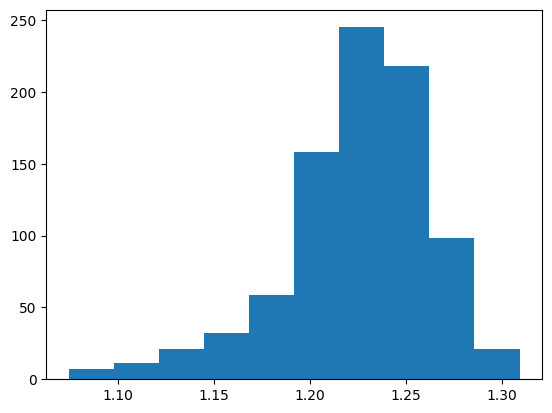

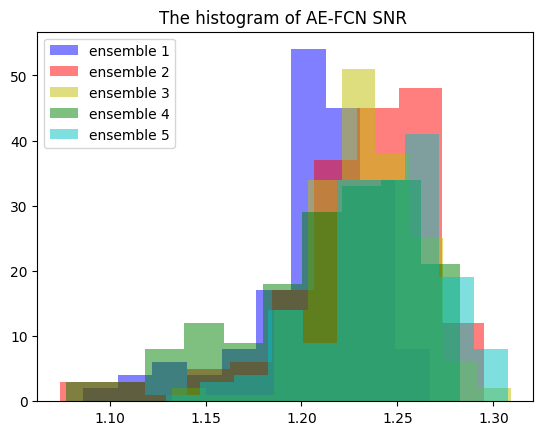

In [ ]:
SNR_aefcn_second = []
total_number = 0

check_ensemble_1 = []
check_ensemble_2 = []
check_ensemble_3 = []
check_ensemble_4 = []
check_ensemble_5 = []

aefcn_subject_mean_second = np.zeros((870,len(index_f[1]) + len(index_s[1])))
aefcn_subject_std_second = np.zeros((870,len(index_f[1]) + len(index_s[1])))
aefcn_subject_snr_second = np.zeros((870,len(index_f[1]) + len(index_s[1])))


for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  for i in range(len(test_index)):
    total_number = total_number + 1
    each_subject = test_index[i]
    print('The', total_number,' subject is ',each_subject)
    f_selected_features = np.zeros((k_fold,19900))
    s_selected_features = np.zeros((k_fold,1417))
    for fold in range(1, k_fold+1):

      smri_ranking = sMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
      fmri_ranking = fMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]

      smooth_name = str(each_subject)+'_'+str(fold)+'_smooth.mat'
      smooth = scio.loadmat(os.path.join(path_aefcn_second, smooth_name))
      smooth = smooth['saliency']
      fmri = smooth[0,0:4000]
      smri = smooth[0,4000:]
      smri_feature_map = match_feature_selection(smri_ranking,smri)
      fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      s_selected_features[fold-1,index_s[1]] = smri_feature_map[0,index_s[1]]+0
      f_selected_features[fold-1,index_f[1]] = fmri_feature_map[0,index_f[1]]+0
      # print(s_selected_features[fold-1,index_s[0]].shape)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # print(fmri_feature_map.shape)
      # print(total_feature_map)
      # total_smooth = total_smooth + total_feature_map
    new_s_selected_features = s_selected_features[:,index_s[1]]
    new_f_selected_features = f_selected_features[:,index_f[1]]
    new_fs_features_map = np.concatenate((new_f_selected_features,new_s_selected_features),axis=1)
    means = np.mean(new_fs_features_map,axis=0)
    aefcn_subject_mean_second[each_subject,:] = means + 0
    stds = np.std(new_fs_features_map,axis=0)
    aefcn_subject_std_second[each_subject,:] = stds + 0
    snrs = means/stds
    nan_indices = np.where(np.isnan(snrs))
    # print(nan_indices)
    # print(len(nan_indices[0]))
    for index in nan_indices[0]:
      if means[index] == 0:
        snrs[index] = 0
      else:
        print('nan because of std ',stds[index])

    aefcn_subject_snr_second[each_subject,:] = snrs + 0

    mean_snr = np.sum(snrs,axis=0) / snrs.shape[0]
    SNR_aefcn_second.append(mean_snr)
    print(mean_snr)

    if ensemble_fold == 0:
      check_ensemble_1.append(mean_snr)
    if ensemble_fold == 1:
      check_ensemble_2.append(mean_snr)
    if ensemble_fold == 2:
      check_ensemble_3.append(mean_snr)
    if ensemble_fold == 3:
      check_ensemble_4.append(mean_snr)
    if ensemble_fold == 4:
      check_ensemble_5.append(mean_snr)


plt.hist(SNR_aefcn_second,bins=10)
plt.show()

plt.hist(check_ensemble_1,alpha=0.5, color='b',label='ensemble 1')
plt.hist(check_ensemble_2,alpha=0.5, color='r',label='ensemble 2')
plt.hist(check_ensemble_3,alpha=0.5, color='y',label='ensemble 3')
plt.hist(check_ensemble_4,alpha=0.5, color='g',label='ensemble 4')
plt.hist(check_ensemble_5,alpha=0.5, color='c',label='ensemble 5')
plt.legend()
plt.title('The histogram of AE-FCN SNR ')
plt.show()

scio.savemat(save_path+'aefcn_snr_second.mat',{'snr':np.array(SNR_aefcn_second)})
scio.savemat(save_path+'aefcn_snr_second_1.mat',{'snr':np.array(check_ensemble_1)})
scio.savemat(save_path+'aefcn_snr_second_2.mat',{'snr':np.array(check_ensemble_2)})
scio.savemat(save_path+'aefcn_snr_second_3.mat',{'snr':np.array(check_ensemble_3)})
scio.savemat(save_path+'aefcn_snr_second_4.mat',{'snr':np.array(check_ensemble_4)})
scio.savemat(save_path+'aefcn_snr_second_5.mat',{'snr':np.array(check_ensemble_5)})



## AE-FCN third

The 1  subject is  828


<ipython-input-16-7fe0e90cfa1f>:49: RuntimeWarning: invalid value encountered in divide
  snrs = means/stds


流式输出内容被截断，只能显示最后 5000 行内容。
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because of std  nan
nan because o

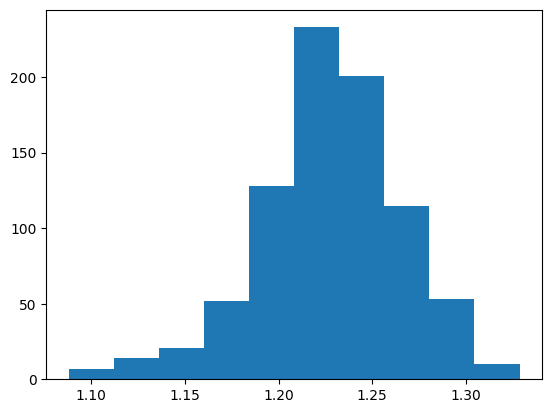

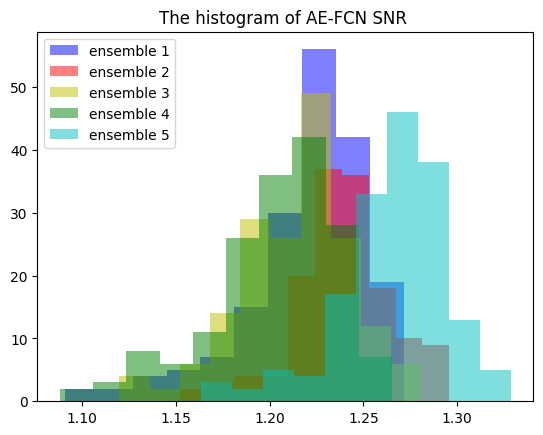

In [ ]:
SNR_aefcn_third = []
total_number = 0

check_ensemble_1 = []
check_ensemble_2 = []
check_ensemble_3 = []
check_ensemble_4 = []
check_ensemble_5 = []

aefcn_subject_mean_third = np.zeros((870,len(index_f[1]) + len(index_s[1])))
aefcn_subject_std_third = np.zeros((870,len(index_f[1]) + len(index_s[1])))
aefcn_subject_snr_third = np.zeros((870,len(index_f[1]) + len(index_s[1])))


for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  for i in range(len(test_index)):
    total_number = total_number + 1
    each_subject = test_index[i]
    print('The', total_number,' subject is ',each_subject)
    f_selected_features = np.zeros((k_fold,19900))
    s_selected_features = np.zeros((k_fold,1417))
    for fold in range(1, k_fold+1):

      smri_ranking = sMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
      fmri_ranking = fMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]

      smooth_name = str(each_subject)+'_'+str(fold)+'_smooth.mat'
      smooth = scio.loadmat(os.path.join(path_aefcn_third, smooth_name))
      smooth = smooth['saliency']
      fmri = smooth[0,0:4000]
      smri = smooth[0,4000:]
      smri_feature_map = match_feature_selection(smri_ranking,smri)
      fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      s_selected_features[fold-1,index_s[1]] = smri_feature_map[0,index_s[1]]+0
      f_selected_features[fold-1,index_f[1]] = fmri_feature_map[0,index_f[1]]+0
      # print(s_selected_features[fold-1,index_s[0]].shape)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # print(fmri_feature_map.shape)
      # print(total_feature_map)
      # total_smooth = total_smooth + total_feature_map
    new_s_selected_features = s_selected_features[:,index_s[1]]
    new_f_selected_features = f_selected_features[:,index_f[1]]
    new_fs_features_map = np.concatenate((new_f_selected_features,new_s_selected_features),axis=1)
    means = np.mean(new_fs_features_map,axis=0)
    aefcn_subject_mean_third[each_subject,:] = means + 0
    stds = np.std(new_fs_features_map,axis=0)
    aefcn_subject_std_third[each_subject,:] = stds + 0
    snrs = means/stds
    nan_indices = np.where(np.isnan(snrs))
    # print(nan_indices)
    # print(len(nan_indices[0]))
    for index in nan_indices[0]:
      if means[index] == 0:
        snrs[index] = 0
      else:
        print('nan because of std ',stds[index])

    aefcn_subject_snr_third[each_subject,:] = snrs + 0

    mean_snr = np.sum(snrs,axis=0) / snrs.shape[0]
    SNR_aefcn_third.append(mean_snr)
    print(mean_snr)

    if ensemble_fold == 0:
      check_ensemble_1.append(mean_snr)
    if ensemble_fold == 1:
      check_ensemble_2.append(mean_snr)
    if ensemble_fold == 2:
      check_ensemble_3.append(mean_snr)
    if ensemble_fold == 3:
      check_ensemble_4.append(mean_snr)
    if ensemble_fold == 4:
      check_ensemble_5.append(mean_snr)


plt.hist(SNR_aefcn_third,bins=10)
plt.show()

plt.hist(check_ensemble_1,alpha=0.5, color='b',label='ensemble 1')
plt.hist(check_ensemble_2,alpha=0.5, color='r',label='ensemble 2')
plt.hist(check_ensemble_3,alpha=0.5, color='y',label='ensemble 3')
plt.hist(check_ensemble_4,alpha=0.5, color='g',label='ensemble 4')
plt.hist(check_ensemble_5,alpha=0.5, color='c',label='ensemble 5')
plt.legend()
plt.title('The histogram of AE-FCN SNR ')
plt.show()

scio.savemat(save_path+'aefcn_snr_third.mat',{'snr':np.array(SNR_aefcn_third)})
scio.savemat(save_path+'aefcn_snr_third_1.mat',{'snr':np.array(check_ensemble_1)})
scio.savemat(save_path+'aefcn_snr_third_2.mat',{'snr':np.array(check_ensemble_2)})
scio.savemat(save_path+'aefcn_snr_third_3.mat',{'snr':np.array(check_ensemble_3)})
scio.savemat(save_path+'aefcn_snr_third_4.mat',{'snr':np.array(check_ensemble_4)})
scio.savemat(save_path+'aefcn_snr_third_5.mat',{'snr':np.array(check_ensemble_5)})



Summary AE-FCN SNR

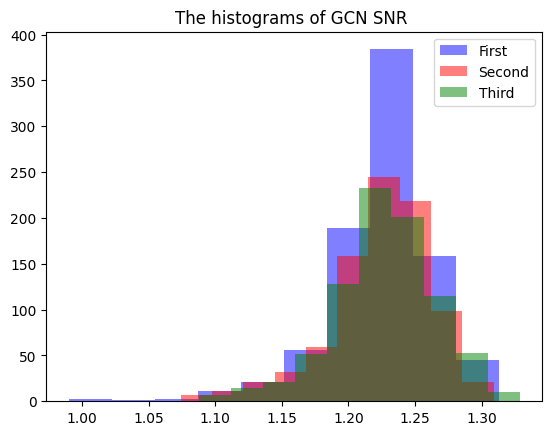

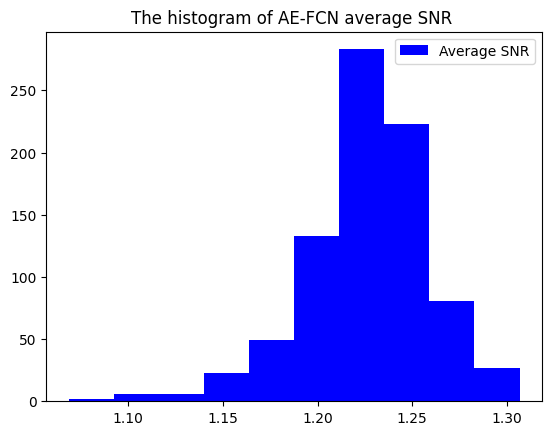

In [ ]:
plt.hist(SNR_aefcn_first,alpha=0.5, color='b',label='First')
plt.hist(SNR_aefcn_second,alpha=0.5, color='r',label='Second')
plt.hist(SNR_aefcn_third,alpha=0.5, color='g',label='Third')
plt.legend()
plt.title('The histograms of AE-FCN SNR ')
plt.show()

array_aefcn_first = np.array(SNR_aefcn_first)
array_aefcn_second = np.array(SNR_aefcn_second)
array_aefcn_third = np.array(SNR_aefcn_third)
aefcn_average_snr = list((array_aefcn_first + array_aefcn_second + array_aefcn_third)/3)

plt.hist(aefcn_average_snr, color='b',label='Average SNR')
plt.legend()
plt.title('The histogram of AE-FCN average SNR ')
plt.show()

## EV-GCN first

The 1  subject is  828


<ipython-input-13-f18a626d66ab>:49: RuntimeWarning: invalid value encountered in divide
  snrs = means/stds


1.0707823431415948
The 2  subject is  835
1.0536766576367629
The 3  subject is  838
1.0825524770831523
The 4  subject is  393
1.0575562599310067
The 5  subject is  395
1.050091921354657
The 6  subject is  400
1.022851073192544
The 7  subject is  461
1.0608745280648144
The 8  subject is  468
1.0221939762481587
The 9  subject is  469
1.036006003996111
The 10  subject is  476
1.05191076624527
The 11  subject is  480
1.0227348096515854
The 12  subject is  485
1.0529743980179977
The 13  subject is  486
1.0042209878648847
The 14  subject is  407
1.0285841204832065
The 15  subject is  408
1.0795660173578427
The 16  subject is  414
1.043522495804476
The 17  subject is  417
1.066799499559988
The 18  subject is  423
1.046529408858939
The 19  subject is  425
1.0064160136189544
The 20  subject is  430
1.0886467440325394
The 21  subject is  436
1.021770055406185
The 22  subject is  442
1.0011186052850847
The 23  subject is  443
0.9843878570756722
The 24  subject is  452
1.030965870060123
The 25  su

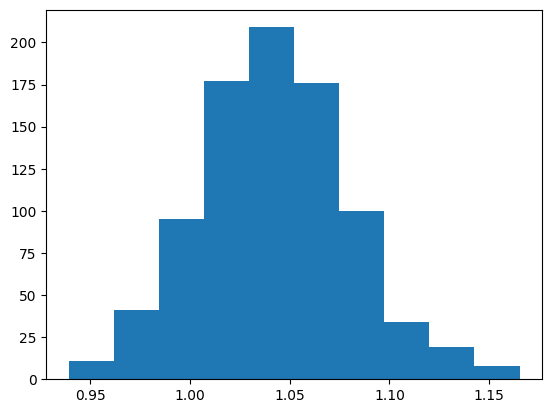

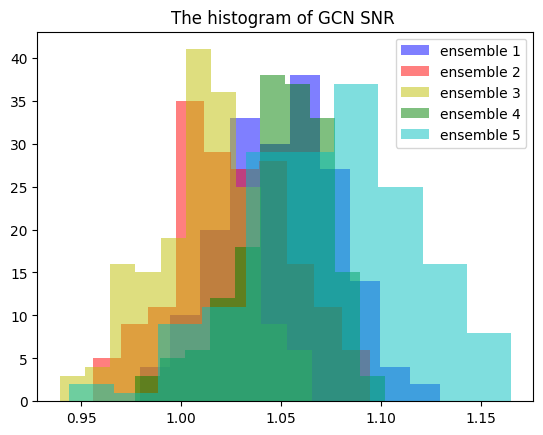

In [ ]:

SNR_evgcn_first = []
total_number = 0

check_ensemble_1 = []
check_ensemble_2 = []
check_ensemble_3 = []
check_ensemble_4 = []
check_ensemble_5 = []


evgcn_subject_mean_first = np.zeros((870,len(index_f[1]) + len(index_s[1])))
evgcn_subject_std_first = np.zeros((870,len(index_f[1]) + len(index_s[1])))
evgcn_subject_snr_first = np.zeros((870,len(index_f[1]) + len(index_s[1])))

for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  for i in range(len(test_index)):
    total_number = total_number + 1
    each_subject = test_index[i]
    print('The', total_number,' subject is ',each_subject)
    f_selected_features = np.zeros((k_fold,19900))
    s_selected_features = np.zeros((k_fold,1417))
    for fold in range(1, k_fold+1):

      smri_ranking = sMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
      fmri_ranking = fMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]

      smooth_name = str(each_subject)+'_'+str(fold)+'_smooth.mat'
      smooth = scio.loadmat(os.path.join(path_evgcn_first, smooth_name))
      smooth = smooth['saliency']
      fmri = smooth[0,0:4000]
      smri = smooth[0,4000:]
      smri_feature_map = match_feature_selection(smri_ranking,smri)
      fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      s_selected_features[fold-1,index_s[1]] = smri_feature_map[0,index_s[1]]+0
      f_selected_features[fold-1,index_f[1]] = fmri_feature_map[0,index_f[1]]+0
      # print(s_selected_features[fold-1,index_s[0]].shape)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # print(fmri_feature_map.shape)
      # print(total_feature_map)
      # total_smooth = total_smooth + total_feature_map
    new_s_selected_features = s_selected_features[:,index_s[1]]
    new_f_selected_features = f_selected_features[:,index_f[1]]
    new_fs_features_map = np.concatenate((new_f_selected_features,new_s_selected_features),axis=1)
    means = np.mean(new_fs_features_map,axis=0)
    evgcn_subject_mean_first[each_subject,:] = means + 0
    stds = np.std(new_fs_features_map,axis=0)
    evgcn_subject_std_first[each_subject,:] = stds + 0
    snrs = means/stds
    nan_indices = np.where(np.isnan(snrs))
    # print(nan_indices)
    # print(len(nan_indices[0]))
    for index in nan_indices[0]:
      if means[index] == 0:
        snrs[index] = 0
      else:
        print('nan because of std ',stds[index])

    evgcn_subject_snr_first[each_subject,:] = snrs + 0

    indices_0 = np.where(snrs!=0)
    # print(indices_0[0])
    mean_snr = np.sum(snrs,axis=0) / len(indices_0[0])
    SNR_evgcn_first.append(mean_snr)
    print(mean_snr)
    # print(len(nan_indices[0]))
    if ensemble_fold == 0:
      check_ensemble_1.append(mean_snr)
    if ensemble_fold == 1:
      check_ensemble_2.append(mean_snr)
    if ensemble_fold == 2:
      check_ensemble_3.append(mean_snr)
    if ensemble_fold == 3:
      check_ensemble_4.append(mean_snr)
    if ensemble_fold == 4:
      check_ensemble_5.append(mean_snr)


plt.hist(SNR_evgcn_first,bins=10)
plt.show()

plt.hist(check_ensemble_1,alpha=0.5, color='b',label='ensemble 1')
plt.hist(check_ensemble_2,alpha=0.5, color='r',label='ensemble 2')
plt.hist(check_ensemble_3,alpha=0.5, color='y',label='ensemble 3')
plt.hist(check_ensemble_4,alpha=0.5, color='g',label='ensemble 4')
plt.hist(check_ensemble_5,alpha=0.5, color='c',label='ensemble 5')
plt.legend()
plt.title('The histogram of GCN SNR ')
plt.show()

scio.savemat(save_path+'evgcn_snr_first.mat',{'snr':np.array(SNR_evgcn_first)})
scio.savemat(save_path+'evgcn_snr_first_1.mat',{'snr':np.array(check_ensemble_1)})
scio.savemat(save_path+'evgcn_snr_first_2.mat',{'snr':np.array(check_ensemble_2)})
scio.savemat(save_path+'evgcn_snr_first_3.mat',{'snr':np.array(check_ensemble_3)})
scio.savemat(save_path+'evgcn_snr_first_4.mat',{'snr':np.array(check_ensemble_4)})
scio.savemat(save_path+'evgcn_snr_first_5.mat',{'snr':np.array(check_ensemble_5)})

## EV-GCN second

The 1  subject is  828


<ipython-input-14-01e16fac9371>:49: RuntimeWarning: invalid value encountered in divide
  snrs = means/stds


0.971003572726484
The 2  subject is  835
0.9320353440758606
The 3  subject is  838
0.9975741130543466
The 4  subject is  393
0.9824852159541697
The 5  subject is  395
0.9900211340873679
The 6  subject is  400
0.9688579412888652
The 7  subject is  461
1.007595633374966
The 8  subject is  468
0.966050430532586
The 9  subject is  469
0.9919633008889233
The 10  subject is  476
1.0003095623246838
The 11  subject is  480
1.0271332125183728
The 12  subject is  485
1.0072590318804788
The 13  subject is  486
0.9765843137741979
The 14  subject is  407
1.0076643948231596
The 15  subject is  408
1.0352278037811655
The 16  subject is  414
1.0328437099281245
The 17  subject is  417
1.0321813104435986
The 18  subject is  423
0.9904409101489927
The 19  subject is  425
1.0231085437654102
The 20  subject is  430
1.031927091893297
The 21  subject is  436
0.9362497104019482
The 22  subject is  442
0.92770847881384
The 23  subject is  443
1.0345021282805478
The 24  subject is  452
0.9629154111886269
The 25

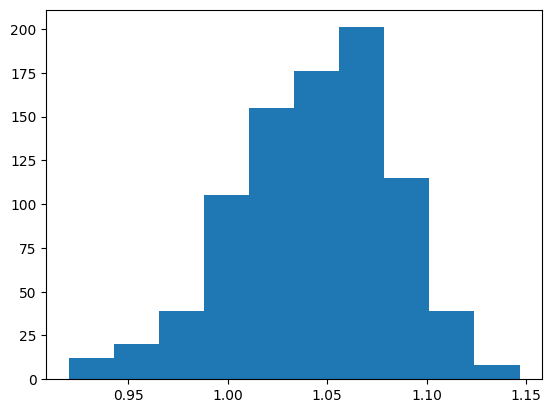

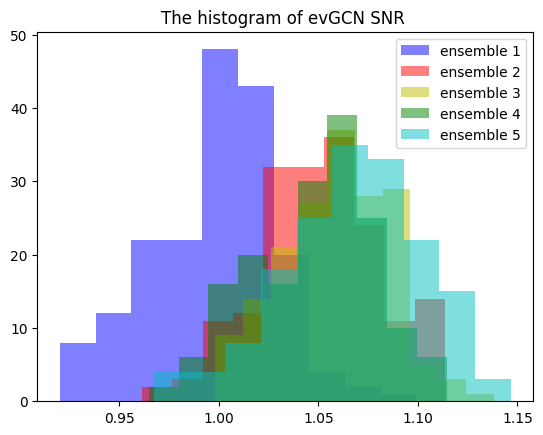

In [ ]:

SNR_evgcn_second = []
total_number = 0

check_ensemble_1 = []
check_ensemble_2 = []
check_ensemble_3 = []
check_ensemble_4 = []
check_ensemble_5 = []


evgcn_subject_mean_second = np.zeros((870,len(index_f[1]) + len(index_s[1])))
evgcn_subject_std_second = np.zeros((870,len(index_f[1]) + len(index_s[1])))
evgcn_subject_snr_second = np.zeros((870,len(index_f[1]) + len(index_s[1])))

for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  for i in range(len(test_index)):
    total_number = total_number + 1
    each_subject = test_index[i]
    print('The', total_number,' subject is ',each_subject)
    f_selected_features = np.zeros((k_fold,19900))
    s_selected_features = np.zeros((k_fold,1417))
    for fold in range(1, k_fold+1):

      smri_ranking = sMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
      fmri_ranking = fMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]

      smooth_name = str(each_subject)+'_'+str(fold)+'_smooth.mat'
      smooth = scio.loadmat(os.path.join(path_evgcn_second, smooth_name))
      smooth = smooth['saliency']
      fmri = smooth[0,0:4000]
      smri = smooth[0,4000:]
      smri_feature_map = match_feature_selection(smri_ranking,smri)
      fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      s_selected_features[fold-1,index_s[1]] = smri_feature_map[0,index_s[1]]+0
      f_selected_features[fold-1,index_f[1]] = fmri_feature_map[0,index_f[1]]+0
      # print(s_selected_features[fold-1,index_s[0]].shape)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # print(fmri_feature_map.shape)
      # print(total_feature_map)
      # total_smooth = total_smooth + total_feature_map
    new_s_selected_features = s_selected_features[:,index_s[1]]
    new_f_selected_features = f_selected_features[:,index_f[1]]
    new_fs_features_map = np.concatenate((new_f_selected_features,new_s_selected_features),axis=1)
    means = np.mean(new_fs_features_map,axis=0)
    evgcn_subject_mean_second[each_subject,:] = means + 0
    stds = np.std(new_fs_features_map,axis=0)
    evgcn_subject_std_second[each_subject,:] = stds + 0
    snrs = means/stds
    nan_indices = np.where(np.isnan(snrs))
    # print(nan_indices)
    # print(len(nan_indices[0]))
    for index in nan_indices[0]:
      if means[index] == 0:
        snrs[index] = 0
      else:
        print('nan because of std ',stds[index])

    evgcn_subject_snr_second[each_subject,:] = snrs + 0

    indices_0 = np.where(snrs!=0)
    # print(indices_0[0])
    mean_snr = np.sum(snrs,axis=0) / len(indices_0[0])
    SNR_evgcn_second.append(mean_snr)
    print(mean_snr)
    # print(len(nan_indices[0]))
    if ensemble_fold == 0:
      check_ensemble_1.append(mean_snr)
    if ensemble_fold == 1:
      check_ensemble_2.append(mean_snr)
    if ensemble_fold == 2:
      check_ensemble_3.append(mean_snr)
    if ensemble_fold == 3:
      check_ensemble_4.append(mean_snr)
    if ensemble_fold == 4:
      check_ensemble_5.append(mean_snr)


plt.hist(SNR_evgcn_second,bins=10)
plt.show()

plt.hist(check_ensemble_1,alpha=0.5, color='b',label='ensemble 1')
plt.hist(check_ensemble_2,alpha=0.5, color='r',label='ensemble 2')
plt.hist(check_ensemble_3,alpha=0.5, color='y',label='ensemble 3')
plt.hist(check_ensemble_4,alpha=0.5, color='g',label='ensemble 4')
plt.hist(check_ensemble_5,alpha=0.5, color='c',label='ensemble 5')
plt.legend()
plt.title('The histogram of evGCN SNR ')
plt.show()

scio.savemat(save_path+'evgcn_snr_second.mat',{'snr':np.array(SNR_evgcn_second)})
scio.savemat(save_path+'evgcn_snr_second_1.mat',{'snr':np.array(check_ensemble_1)})
scio.savemat(save_path+'evgcn_snr_second_2.mat',{'snr':np.array(check_ensemble_2)})
scio.savemat(save_path+'evgcn_snr_second_3.mat',{'snr':np.array(check_ensemble_3)})
scio.savemat(save_path+'evgcn_snr_second_4.mat',{'snr':np.array(check_ensemble_4)})
scio.savemat(save_path+'evgcn_snr_second_5.mat',{'snr':np.array(check_ensemble_5)})

## EV-GCN Third

The 1  subject is  828


<ipython-input-15-1d1c6206787f>:49: RuntimeWarning: invalid value encountered in divide
  snrs = means/stds


1.0258381454613816
The 2  subject is  835
1.025358469937204
The 3  subject is  838
1.0052871234309293
The 4  subject is  393
1.033717906304301
The 5  subject is  395
1.037372189269162
The 6  subject is  400
1.0192508341257556
The 7  subject is  461
1.0900212415096826
The 8  subject is  468
1.0294872878623076
The 9  subject is  469
1.0653862323895407
The 10  subject is  476
1.0476258193342982
The 11  subject is  480
1.0603354442990984
The 12  subject is  485
1.021750416352207
The 13  subject is  486
1.0659517049921645
The 14  subject is  407
1.0653184238540652
The 15  subject is  408
1.044233425397598
The 16  subject is  414
1.055087996809829
The 17  subject is  417
1.0703397781630337
The 18  subject is  423
1.0271028405835478
The 19  subject is  425
1.0312929957265924
The 20  subject is  430
1.012068888183445
The 21  subject is  436
1.0114503501497887
The 22  subject is  442
0.9992785114855202
The 23  subject is  443
1.020016843639058
The 24  subject is  452
1.035514378839293
The 25  s

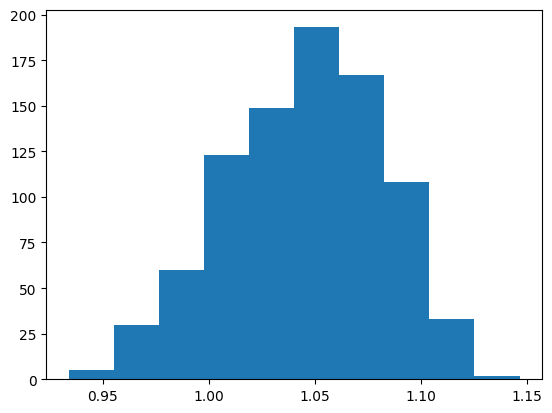

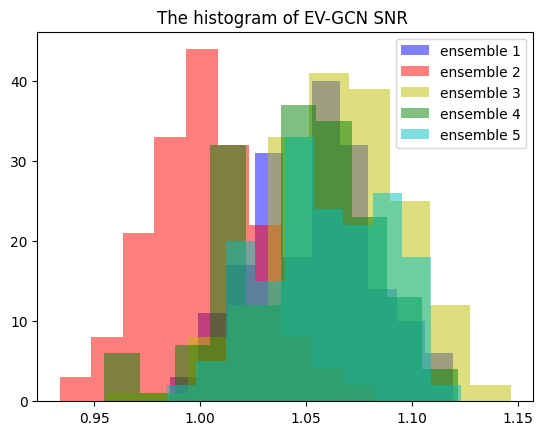

In [ ]:

SNR_evgcn_third = []
total_number = 0

check_ensemble_1 = []
check_ensemble_2 = []
check_ensemble_3 = []
check_ensemble_4 = []
check_ensemble_5 = []


evgcn_subject_mean_third = np.zeros((870,len(index_f[1]) + len(index_s[1])))
evgcn_subject_std_third = np.zeros((870,len(index_f[1]) + len(index_s[1])))
evgcn_subject_snr_third = np.zeros((870,len(index_f[1]) + len(index_s[1])))

for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  for i in range(len(test_index)):
    total_number = total_number + 1
    each_subject = test_index[i]
    print('The', total_number,' subject is ',each_subject)
    f_selected_features = np.zeros((k_fold,19900))
    s_selected_features = np.zeros((k_fold,1417))
    for fold in range(1, k_fold+1):

      smri_ranking = sMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
      fmri_ranking = fMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]

      smooth_name = str(each_subject)+'_'+str(fold)+'_smooth.mat'
      smooth = scio.loadmat(os.path.join(path_evgcn_third, smooth_name))
      smooth = smooth['saliency']
      fmri = smooth[0,0:4000]
      smri = smooth[0,4000:]
      smri_feature_map = match_feature_selection(smri_ranking,smri)
      fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      s_selected_features[fold-1,index_s[1]] = smri_feature_map[0,index_s[1]]+0
      f_selected_features[fold-1,index_f[1]] = fmri_feature_map[0,index_f[1]]+0
      # print(s_selected_features[fold-1,index_s[0]].shape)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # print(fmri_feature_map.shape)
      # print(total_feature_map)
      # total_smooth = total_smooth + total_feature_map
    new_s_selected_features = s_selected_features[:,index_s[1]]
    new_f_selected_features = f_selected_features[:,index_f[1]]
    new_fs_features_map = np.concatenate((new_f_selected_features,new_s_selected_features),axis=1)
    means = np.mean(new_fs_features_map,axis=0)
    evgcn_subject_mean_third[each_subject,:] = means + 0
    stds = np.std(new_fs_features_map,axis=0)
    evgcn_subject_std_third[each_subject,:] = stds + 0
    snrs = means/stds
    nan_indices = np.where(np.isnan(snrs))
    # print(nan_indices)
    # print(len(nan_indices[0]))
    for index in nan_indices[0]:
      if means[index] == 0:
        snrs[index] = 0
      else:
        print('nan because of std ',stds[index])

    evgcn_subject_snr_third[each_subject,:] = snrs + 0

    indices_0 = np.where(snrs!=0)
    # print(indices_0[0])
    mean_snr = np.sum(snrs,axis=0) / len(indices_0[0])
    SNR_evgcn_third.append(mean_snr)
    print(mean_snr)
    # print(len(nan_indices[0]))
    if ensemble_fold == 0:
      check_ensemble_1.append(mean_snr)
    if ensemble_fold == 1:
      check_ensemble_2.append(mean_snr)
    if ensemble_fold == 2:
      check_ensemble_3.append(mean_snr)
    if ensemble_fold == 3:
      check_ensemble_4.append(mean_snr)
    if ensemble_fold == 4:
      check_ensemble_5.append(mean_snr)


plt.hist(SNR_evgcn_third,bins=10)
plt.show()

plt.hist(check_ensemble_1,alpha=0.5, color='b',label='ensemble 1')
plt.hist(check_ensemble_2,alpha=0.5, color='r',label='ensemble 2')
plt.hist(check_ensemble_3,alpha=0.5, color='y',label='ensemble 3')
plt.hist(check_ensemble_4,alpha=0.5, color='g',label='ensemble 4')
plt.hist(check_ensemble_5,alpha=0.5, color='c',label='ensemble 5')
plt.legend()
plt.title('The histogram of EV-GCN SNR ')
plt.show()

scio.savemat(save_path+'evgcn_snr_third.mat',{'snr':np.array(SNR_evgcn_third)})
scio.savemat(save_path+'evgcn_snr_third_1.mat',{'snr':np.array(check_ensemble_1)})
scio.savemat(save_path+'evgcn_snr_third_2.mat',{'snr':np.array(check_ensemble_2)})
scio.savemat(save_path+'evgcn_snr_third_3.mat',{'snr':np.array(check_ensemble_3)})
scio.savemat(save_path+'evgcn_snr_third_4.mat',{'snr':np.array(check_ensemble_4)})
scio.savemat(save_path+'evgcn_snr_third_5.mat',{'snr':np.array(check_ensemble_5)})

Summary EV-GCN SNR

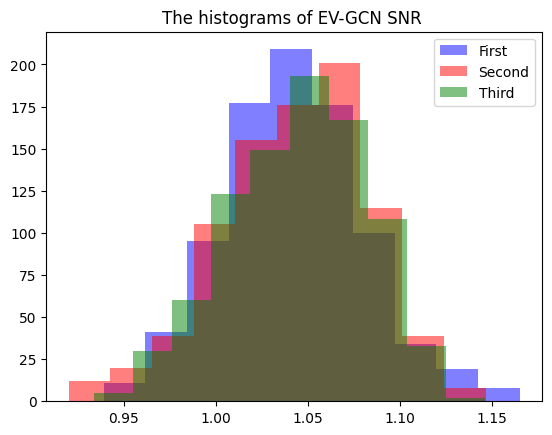

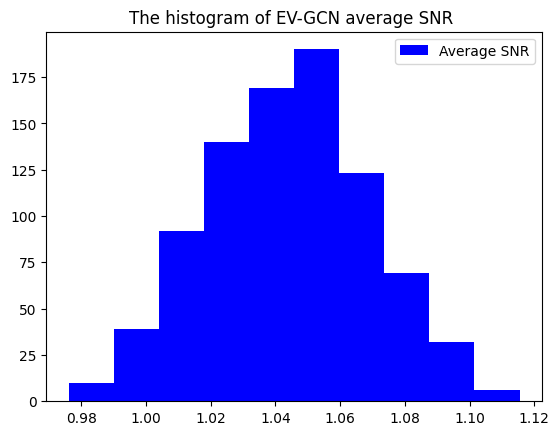

In [ ]:
plt.hist(SNR_evgcn_first,alpha=0.5, color='b',label='First')
plt.hist(SNR_evgcn_second,alpha=0.5, color='r',label='Second')
plt.hist(SNR_evgcn_third,alpha=0.5, color='g',label='Third')
plt.legend()
plt.title('The histograms of EV-GCN SNR ')
plt.show()

array_evgcn_first = np.array(SNR_evgcn_first)
array_evgcn_second = np.array(SNR_evgcn_second)
array_evgcn_third = np.array(SNR_evgcn_third)
evgcn_average_snr = list((array_evgcn_first + array_evgcn_second + array_evgcn_third)/3)

plt.hist(evgcn_average_snr, color='b',label='Average SNR')
plt.legend()
plt.title('The histogram of EV-GCN average SNR ')
plt.show()

# The histograms of FCN, GCN and AE-FCN average SNR

Load the matrices from google drive

In [ ]:
# load fcn matric
import scipy.io as scio
import os
import matplotlib.pyplot as plt

save_path = '/content/drive/MyDrive/ABIDE/test_save_selected_features/'

array_fcn_first = scio.loadmat(os.path.join(save_path, 'fcn_snr_first.mat'))
array_fcn_second = scio.loadmat(os.path.join(save_path, 'fcn_snr_second.mat'))
array_fcn_third = scio.loadmat(os.path.join(save_path, 'fcn_snr_third.mat'))
array_fcn_first = array_fcn_first['snr']
array_fcn_second = array_fcn_second['snr']
array_fcn_third = array_fcn_third['snr']
fcn_average_snr = list((array_fcn_first + array_fcn_second + array_fcn_third)/3)

# load gcn matric
array_gcn_first = scio.loadmat(os.path.join(save_path, 'gcn_snr_first.mat'))
array_gcn_second = scio.loadmat(os.path.join(save_path, 'gcn_snr_second.mat'))
array_gcn_third = scio.loadmat(os.path.join(save_path, 'gcn_snr_third.mat'))
array_gcn_first = array_gcn_first['snr']
array_gcn_second = array_gcn_second['snr']
array_gcn_third = array_gcn_third['snr']
gcn_average_snr = list((array_gcn_first + array_gcn_second + array_gcn_third)/3)

# load fcn matric
array_aefcn_first = scio.loadmat(os.path.join(save_path, 'aefcn_snr_first.mat'))
array_aefcn_second = scio.loadmat(os.path.join(save_path, 'aefcn_snr_second.mat'))
array_aefcn_third = scio.loadmat(os.path.join(save_path, 'aefcn_snr_third.mat'))
array_aefcn_first = array_aefcn_first['snr']
array_aefcn_second = array_aefcn_second['snr']
array_aefcn_third = array_aefcn_third['snr']
aefcn_average_snr = list((array_aefcn_first + array_aefcn_second + array_aefcn_third)/3)

# load evgcn matric
array_evgcn_first = scio.loadmat(os.path.join(save_path, 'evgcn_snr_first.mat'))
array_evgcn_second = scio.loadmat(os.path.join(save_path, 'evgcn_snr_second.mat'))
array_evgcn_third = scio.loadmat(os.path.join(save_path, 'evgcn_snr_third.mat'))
array_evgcn_first = array_evgcn_first['snr']
array_evgcn_second = array_evgcn_second['snr']
array_evgcn_third = array_evgcn_third['snr']
evgcn_average_snr = list((array_evgcn_first + array_evgcn_second + array_evgcn_third)/3)

# scio.loadmat(os.path.join(folder_path, name))

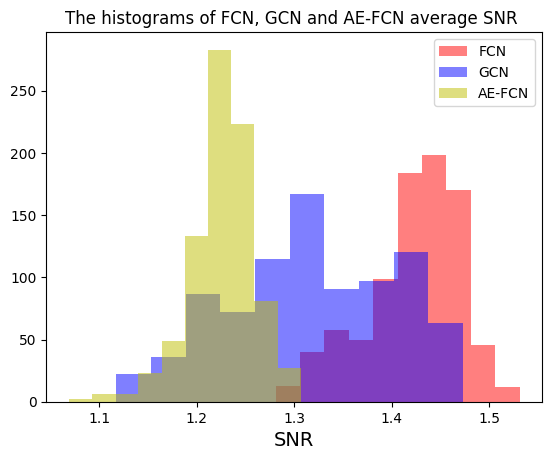

In [ ]:
plt.hist(fcn_average_snr,alpha=0.5, color='r',label='FCN')
plt.hist(gcn_average_snr,alpha=0.5, color='b',label='GCN')
plt.hist(aefcn_average_snr,alpha=0.5, color='y',label='AE-FCN')
plt.legend()
plt.title('The histograms of FCN, GCN and AE-FCN average SNR ')
plt.xlabel('SNR', fontsize=14)
plt.show()

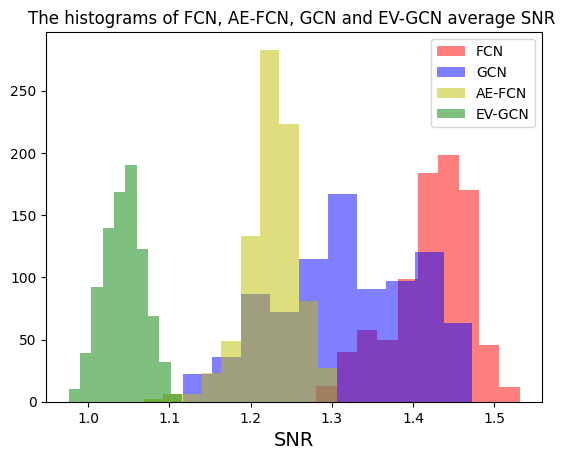

In [ ]:
plt.hist(fcn_average_snr,alpha=0.5, color='r',label='FCN')
plt.hist(gcn_average_snr,alpha=0.5, color='b',label='GCN')
plt.hist(aefcn_average_snr,alpha=0.5, color='y',label='AE-FCN')
plt.hist(evgcn_average_snr,alpha=0.5, color='g',label='EV-GCN')
plt.legend()
plt.title('The histograms of FCN, AE-FCN, GCN and EV-GCN average SNR ')
plt.xlabel('SNR', fontsize=14)
plt.show()

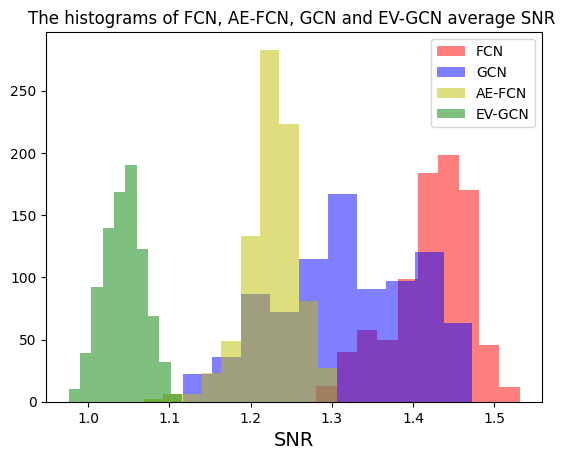

In [ ]:
plt.hist(fcn_average_snr,alpha=0.5, color='r',label='FCN')
plt.hist(gcn_average_snr,alpha=0.5, color='b',label='GCN')
plt.hist(aefcn_average_snr,alpha=0.5, color='y',label='AE-FCN')
plt.hist(evgcn_average_snr,alpha=0.5, color='g',label='EV-GCN')
plt.legend()
plt.title('The histograms of FCN, AE-FCN, GCN and EV-GCN average SNR ')
plt.xlabel('SNR', fontsize=14)
plt.show()

In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

all_models_comparison = [fcn_average_snr, gcn_average_snr, aefcn_average_snr, evgcn_average_snr]
names = ['FCN', 'GCN', 'AE-FCN', 'EV-GCN']
for i in range(len(names)):
  for j in range(i+1,len(names)):
    name_1 = names[i]
    name_2 = names[j]
    data_1 = all_models_comparison[i][0]
    data_2 = all_models_comparison[j][0]
    print(len(data_1))
    print(len(data_1))
    print(name_1)
    print(name_2)
    stat, p = stats.levene(data_1, data_2)
    if p>0.05:
      # print('The variances of these two data are not different')
      t, p_two = stats.ttest_ind(data_1, data_2, equal_var=True)
    else:
      print('The variances of these two data are different')
      t, p_two = stats.ttest_ind(data_1, data_2, equal_var=False)
    print('The p value of these two data is: ', p_two)
    print('\n')

# print(fcn_average_snr)
# print(len(fcn_average_snr[0]))

870
870
FCN
GCN
The variances of these two data are different
The p value of these two data is:  3.2558551690818077e-169


870
870
FCN
AE-FCN
The variances of these two data are different
The p value of these two data is:  nan


870
870
FCN
EV-GCN
The variances of these two data are different
The p value of these two data is:  0.0


870
870
GCN
AE-FCN
The variances of these two data are different
The p value of these two data is:  nan


870
870
GCN
EV-GCN
The variances of these two data are different
The p value of these two data is:  0.0


870
870
AE-FCN
EV-GCN
The variances of these two data are different
The p value of these two data is:  nan




# Mean metrices of FCN, GCN, and AE-FCN, for each subject and feature

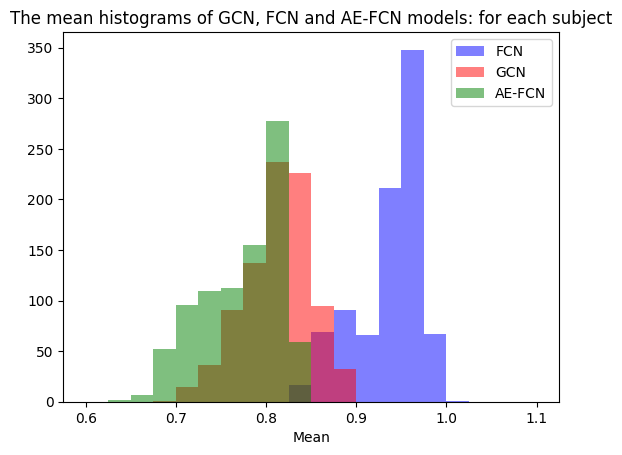

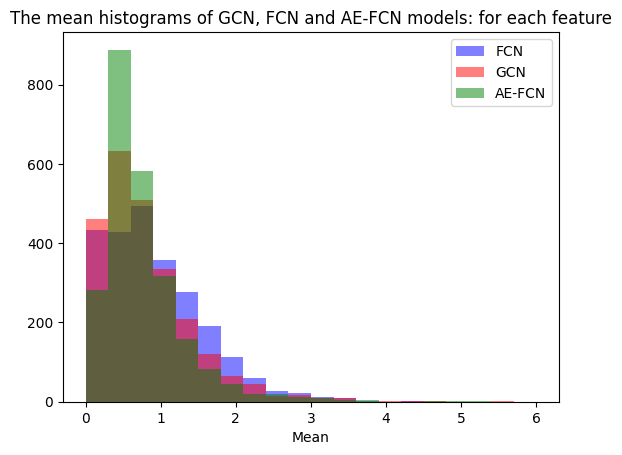

In [ ]:
fcn_subject_average_mean = (fcn_subject_mean_first + fcn_subject_mean_second + fcn_subject_mean_third)/3
gcn_subject_average_mean = (gcn_subject_mean_first + gcn_subject_mean_second + gcn_subject_mean_third)/3
aefcn_subject_average_mean = (aefcn_subject_mean_first + aefcn_subject_mean_second + aefcn_subject_mean_third)/3



gcn_values_subject = np.mean(gcn_subject_average_mean,axis=1)
fcn_values_subject = np.mean(fcn_subject_average_mean,axis=1)
aefcn_values_subject = np.mean(aefcn_subject_average_mean,axis=1)
gcn_values_feature = np.mean(gcn_subject_average_mean,axis=0)
fcn_values_feature = np.mean(fcn_subject_average_mean,axis=0)
aefcn_values_feature = np.mean(aefcn_subject_average_mean,axis=0)


plt.hist(fcn_values_subject,bins=20, alpha=0.5, color='b',range=(0.6,1.1),label='FCN')
plt.hist(gcn_values_subject,bins=20, alpha=0.5, color='r',range=(0.6,1.1),label='GCN')
plt.hist(aefcn_values_subject,bins=20, alpha=0.5, color='g',range=(0.6,1.1),label='AE-FCN')
plt.legend()
plt.title('The mean histograms of GCN, FCN and AE-FCN models: for each subject')
plt.xlabel('Mean')
plt.show()

plt.hist(fcn_values_feature,bins=20, alpha=0.5, color='b',range=(0,6),label='FCN')
plt.hist(gcn_values_feature,bins=20, alpha=0.5, color='r',range=(0,6),label='GCN')
plt.hist(aefcn_values_feature,bins=20, alpha=0.5, color='g',range=(0,6),label='AE-FCN')
plt.legend()
plt.title('The mean histograms of GCN, FCN and AE-FCN models: for each feature')
plt.xlabel('Mean')
plt.show()


# STD metrices of FCN, GCN, and AE-FCN, for each subject and feature

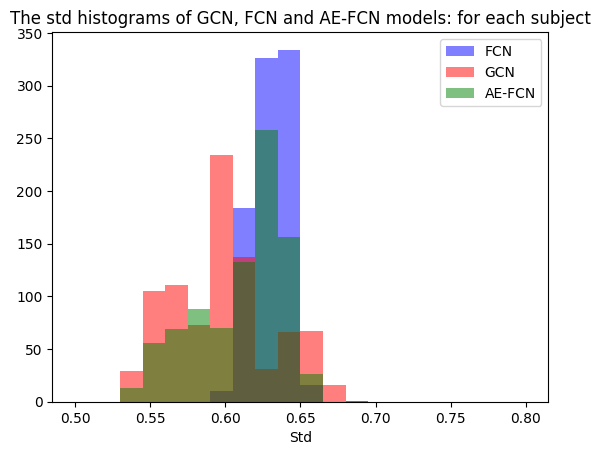

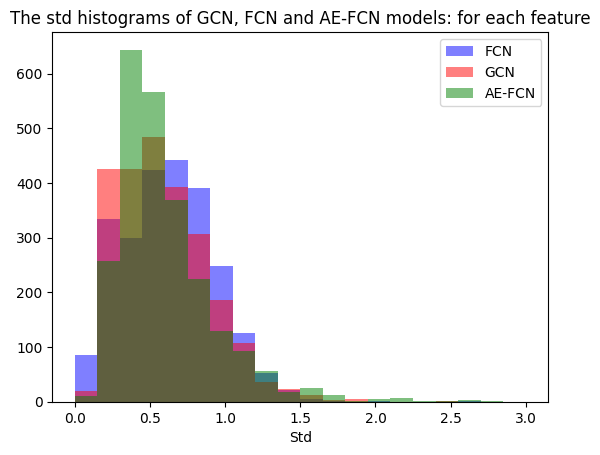

In [ ]:
fcn_subject_average_std = (fcn_subject_std_first + fcn_subject_std_second + fcn_subject_std_third)/3
gcn_subject_average_std = (gcn_subject_std_first + gcn_subject_std_second + gcn_subject_std_third)/3
aefcn_subject_average_std = (aefcn_subject_std_first + aefcn_subject_std_second + aefcn_subject_std_third)/3

gcn_values_subject = np.mean(gcn_subject_average_std,axis=1)
fcn_values_subject = np.mean(fcn_subject_average_std,axis=1)
aefcn_values_subject = np.mean(aefcn_subject_average_std,axis=1)
gcn_values_feature = np.mean(gcn_subject_average_std,axis=0)
fcn_values_feature = np.mean(fcn_subject_average_std,axis=0)
aefcn_values_feature = np.mean(aefcn_subject_average_std,axis=0)

plt.hist(fcn_values_subject,bins=20, alpha=0.5, color='b',range=(0.5,0.8),label='FCN')
plt.hist(gcn_values_subject,bins=20, alpha=0.5, color='r',range=(0.5,0.8),label='GCN')
plt.hist(aefcn_values_subject,bins=20, alpha=0.5, color='g',range=(0.5,0.8),label='AE-FCN')
plt.legend()
plt.title('The std histograms of GCN, FCN and AE-FCN models: for each subject')
plt.xlabel('Std')
plt.show()


plt.hist(fcn_values_feature,bins=20, alpha=0.5, color='b',range=(0,3),label='FCN')
plt.hist(gcn_values_feature,bins=20, alpha=0.5, color='r',range=(0,3),label='GCN')
plt.hist(aefcn_values_feature,bins=20, alpha=0.5, color='g',range=(0,3),label='AE-FCN')
plt.legend()
plt.title('The std histograms of GCN, FCN and AE-FCN models: for each feature')
plt.xlabel('Std')
plt.show()


